# Hoda Dataset
Deep Learning project by using CNNs in the Hoda dataset. The aim of this notebook is the model training with the highest accuracy by considering hyperparameter tuning.

In [ ]:
!git clone https://github.com/amir-saniyan/HodaDatasetReader.git

Cloning into 'HodaDatasetReader'...

remote: Enumerating objects: 24, done.

remote: Total 24 (delta 0), reused 0 (delta 0), pack-reused 24

Receiving objects: 100% (24/24), 6.34 MiB | 18.82 MiB/s, done.

Resolving deltas: 100% (6/6), done.


In [ ]:
from HodaDatasetReader.HodaDatasetReader import read_hoda_dataset

X_train, y_train = read_hoda_dataset('/content/HodaDatasetReader/DigitDB/Train 60000.cdb')
X_test, y_test = read_hoda_dataset('/content/HodaDatasetReader/DigitDB/Test 20000.cdb')

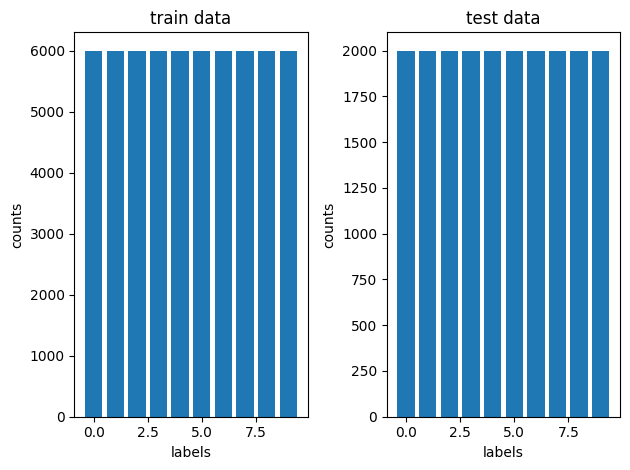

In [ ]:
# Checking the balance of the label
import numpy as np
import matplotlib.pyplot as plt

unique_values, counts = np.unique(y_train, return_counts=True)
plt.subplot(1, 2, 1)
plt.bar(unique_values, counts)
plt.xlabel('labels')
plt.ylabel('counts')
plt.title('train data')

unique_values2, counts2 = np.unique(y_test, return_counts=True)
plt.subplot(1, 2, 2)
plt.bar(unique_values2, counts2)
plt.xlabel('labels')
plt.ylabel('counts')
plt.title('test data')

plt.tight_layout()
plt.show()

So Hoda dataset has balanced labels.

In [ ]:
# reshape (32,32)
X_train = X_train.reshape(-1,32,32,1)
X_test = X_test.reshape(-1,32,32,1)

In [ ]:
n_samples = X_train.shape[0]
n_features = X_train.shape[1:]

In [ ]:
n_classes = len(set(y_train))

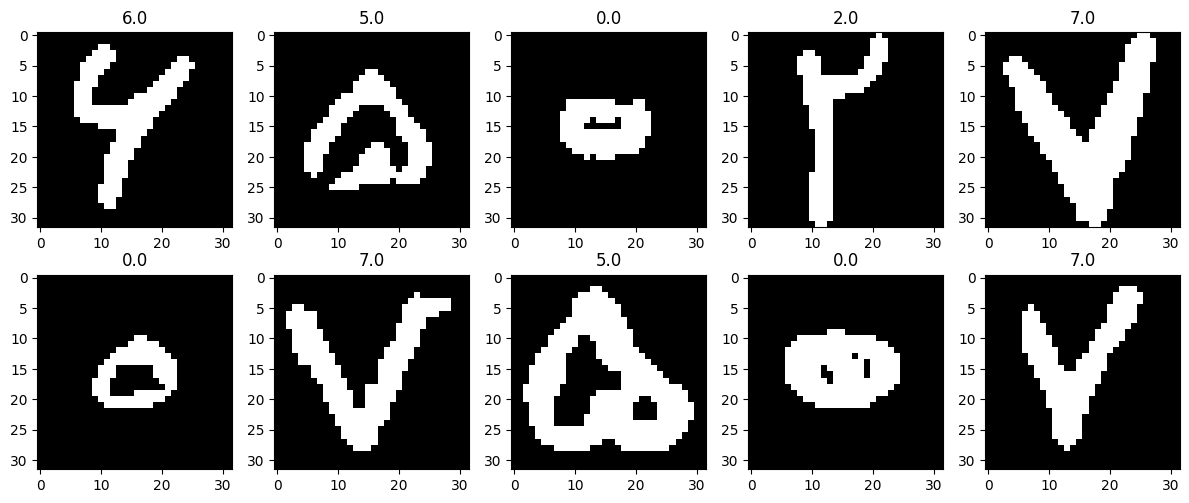

In [ ]:
# visulization
plt.figure(figsize=(12,5))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(X_train[i])
  plt.title(y_train[i])
  plt.gray()

plt.tight_layout()
plt.show()

# CNN network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.initializers import he_normal


# Building the CNN network (Functional API)
def build_neural_network(n_features, n_classes):
    ## define input layer
    inputs = Input(shape=n_features)

    # Add convolutional layers with batch normalization and weight initialization, max-pooling, and dropout
    network_1 = Conv2D(64, kernel_size=(3, 3), kernel_initializer=he_normal(seed=None), activation='relu')(inputs)
    network_2 = BatchNormalization()(network_1)
    network_3 = MaxPooling2D(pool_size=(2, 2))(network_2)
    network_4 = Dropout(0.2)(network_3)

    network_5 = Conv2D(64, kernel_size=(3, 3), kernel_initializer=he_normal(seed=None), activation='relu')(network_4)
    network_6 = BatchNormalization()(network_5)
    network_7 = MaxPooling2D(pool_size=(2, 2))(network_6)
    network_8 = Dropout(0.2)(network_7)

    # Flatten the output and add fully connected layers
    network_9 = Flatten()(network_8)
    network_10 = Dropout(0.2)(network_9)
    network_11 = Dense(128, kernel_initializer=he_normal(seed=None), activation='relu')(network_10)
    network_12 = BatchNormalization()(network_11)
    network_13 = Dropout(0.2)(network_12)

    ##Defining  output layer y1
    output = Dense(n_classes, activation="softmax", name='output')(network_13)

    ##Defining the model by specifying the input and output layers
    model = Model(inputs=inputs, outputs=output)

    # print(model.summary())

    return model

# Hyperparameter Tuning
In this notebook, hyperparameter tuning is done to determine the best ***optimizer***, ***learning rate***, and ***batch size***.

# Selecting best optimizer

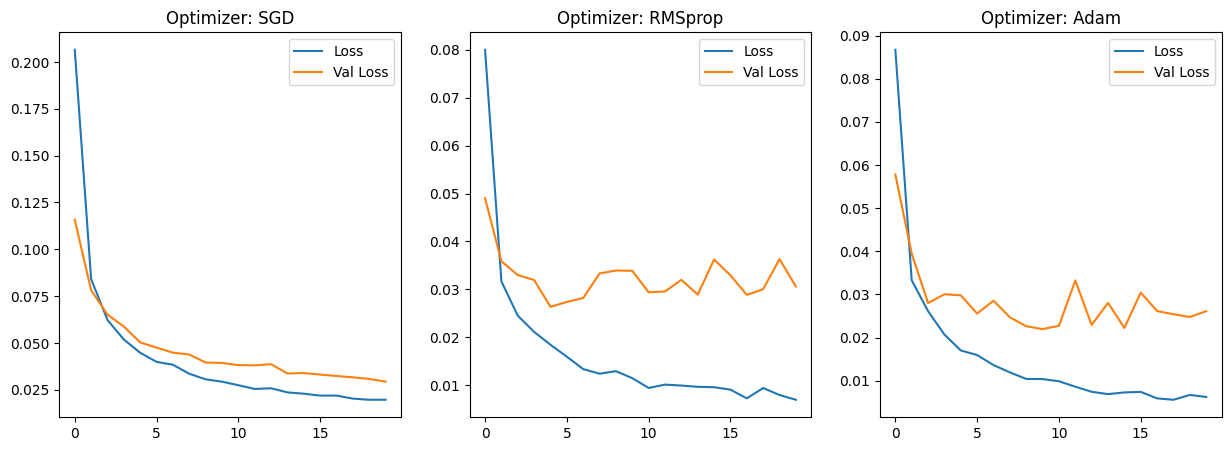

In [ ]:
optimizers = [tf.keras.optimizers.SGD(), tf.keras.optimizers.RMSprop(), tf.keras.optimizers.Adam()]

# Prepare the subplot figure
fig, axes = plt.subplots(1, len(optimizers), figsize=(15, 5))
# fig.subplots_adjust(hspace=0.5, wspace=0.5)

metric = tf.keras.metrics.SparseCategoricalAccuracy()
loss = tf.keras.losses.SparseCategoricalCrossentropy()

# Loop over optimizers
for i, optimizer in enumerate(optimizers):
    network = build_neural_network(n_features, n_classes)
    network.compile(optimizer=optimizer, loss=loss, metrics=metric)
    history = network.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=20, verbose=0)

    # Plotting the loss and validation loss
    ax = axes[i]
    ax.plot(history.history['loss'], label='Loss')
    ax.plot(history.history['val_loss'], label='Val Loss')

    # Setting the subplot title
    ax.set_title(f'Optimizer: {optimizer.get_config()["name"]}')

    # Adding the legend
    ax.legend()

# Show the plot
plt.show()

According above figures, we can see that loss and val-loss have more smoothest curve in the SGD optimizer.

---

However, since Adam's optimizer has more advantages than SGD, I decided to evaluate Adam's optimizer with different values of batch size and learning rate. I try to find the appropriate hyperparameter in the Adam optimizer.

---

in the final step, the best version of Adam is compared with the SGD optimizer.



# Selecting the best batch size and learning rate in Adam's optimizer


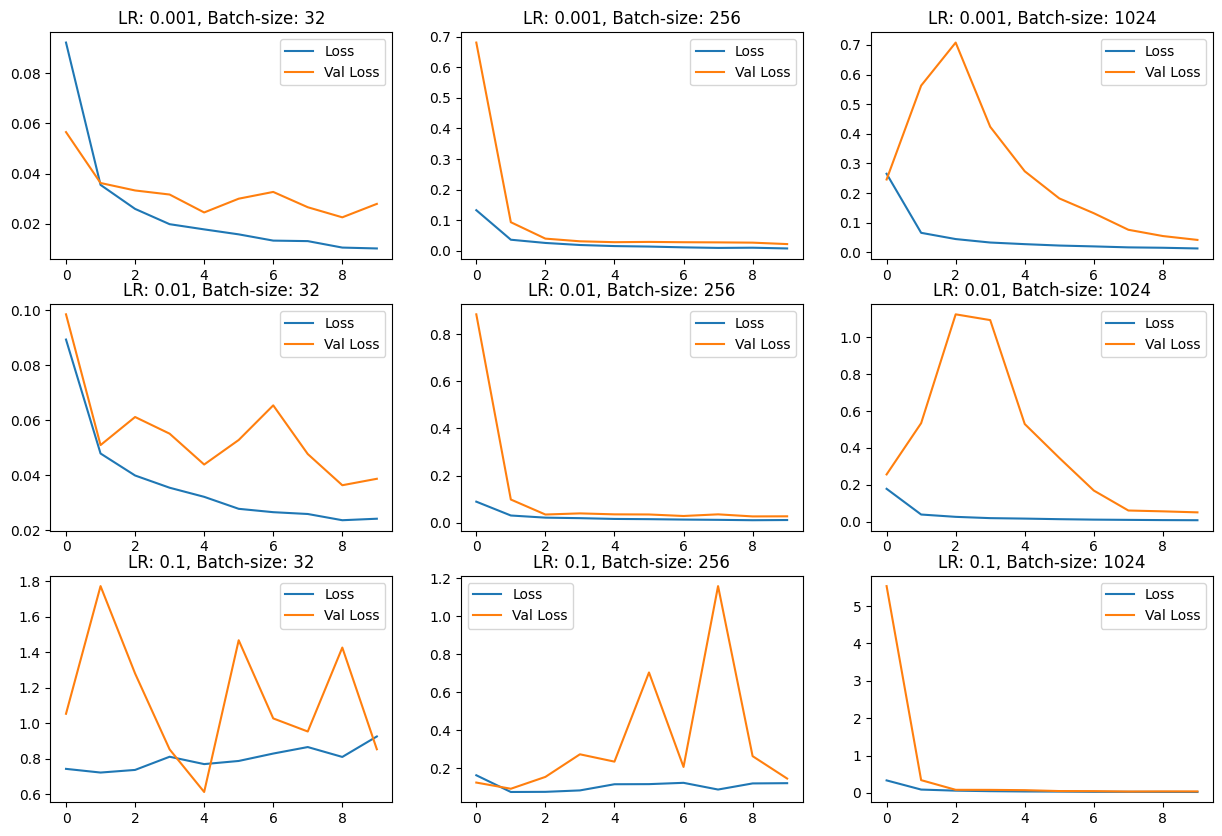

In [ ]:
# Possible learning rates and batch sizes
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 256, 1024]

fig, axes = plt.subplots(len(learning_rates), len(batch_sizes), figsize=(15, 10))
# fig.subplots_adjust(hspace=0.5, wspace=0.5)


metric = tf.keras.metrics.SparseCategoricalAccuracy()
loss = tf.keras.losses.SparseCategoricalCrossentropy()

for i, lr in enumerate(learning_rates):
    for j, batch_size in enumerate(batch_sizes):
        network = build_neural_network(n_features, n_classes)
        network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss, metrics=metric)
        history = network.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=10, verbose=0)

        # Plotting the loss and validation loss
        ax = axes[i, j]
        ax.plot(history.history['loss'], label='Loss')
        ax.plot(history.history['val_loss'], label='Val Loss')

        # Setting the subplot title
        ax.set_title(f'LR: {lr}, Batch-size: {batch_size}')

        # Adding the legend
        ax.legend()

# Show the plot
plt.show()

According above results, 0.001 is the best learning rate.

---

However, to determine the best batch size, we need more epochs

---

Furthermore, the results show if we add a regularization term in this network, maybe we get a better val-loss curve.


In [ ]:
from keras import regularizers

def build_neural_network_with_regularization(n_features, n_classes, reg_param=0.01):
    ## define input layer
    inputs = Input(shape=n_features)


    # Add convolutional layers with batch normalization and weight initialization, max-pooling, and dropout
    network_1 = Conv2D(64, kernel_size=(3, 3), kernel_initializer=he_normal(seed=None), activation='relu',
                       kernel_regularizer=regularizers.l2(reg_param))(inputs)
    network_2 = BatchNormalization()(network_1)
    network_3 = MaxPooling2D(pool_size=(2, 2))(network_2)
    network_4 = Dropout(0.2)(network_3)


    network_5 = Conv2D(64, kernel_size=(3, 3), kernel_initializer=he_normal(seed=None), activation='relu',
                       kernel_regularizer=regularizers.l2(reg_param))(network_4)
    network_6 = BatchNormalization()(network_5)
    network_7 = MaxPooling2D(pool_size=(2, 2))(network_6)
    network_8 = Dropout(0.2)(network_7)


    # Flatten the output and add fully connected layers
    network_9 = Flatten()(network_8)
    network_10 = Dropout(0.2)(network_9)
    network_11 = Dense(128, kernel_initializer=he_normal(seed=None), activation='relu',
                       kernel_regularizer=regularizers.l2(reg_param))(network_10)
    network_12 = BatchNormalization()(network_11)
    network_13 = Dropout(0.2)(network_12)


    ##Defining  output layer y1
    output = Dense(n_classes, activation="softmax", name='output')(network_13)


    ##Defining the model by specifying the input and output layers
    model = Model(inputs=inputs, outputs=output)


    # print(model.summary())


    return model

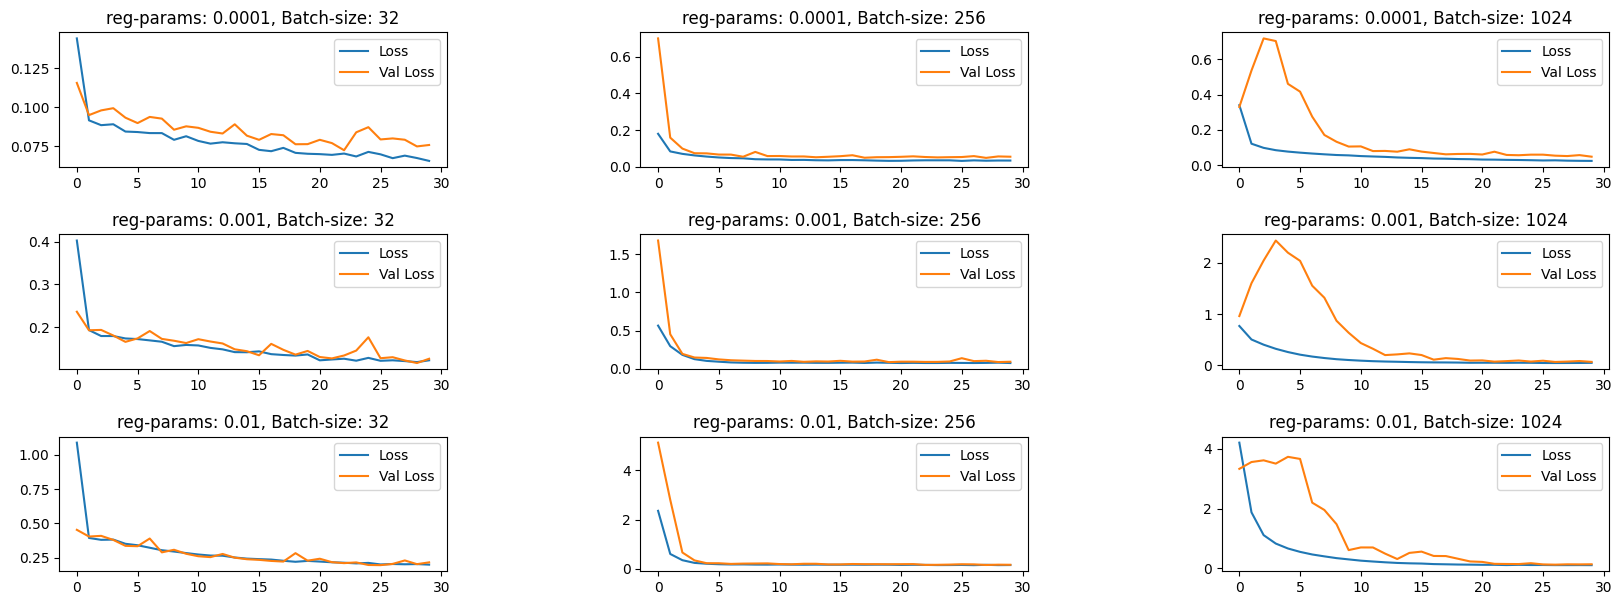

In [ ]:
# Possible learning rates and batch sizes
# learning_rates = [0.001]
batch_sizes = [32, 256, 1024]
reg_params = [0.0001, 0.001, 0.01]

fig, axes = plt.subplots(len(reg_params), len(batch_sizes), figsize=(20, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.5)


metric = tf.keras.metrics.SparseCategoricalAccuracy()
loss = tf.keras.losses.SparseCategoricalCrossentropy()

for i, r_param in enumerate(reg_params):
    for j, batch_size in enumerate(batch_sizes):
      network = build_neural_network_with_regularization(n_features, n_classes, reg_param=r_param)
      network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=loss, metrics=metric)
      history = network.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=30, verbose=0)

      # Plotting the loss and validation loss
      ax = axes[i, j]
      ax.plot(history.history['loss'], label='Loss')
      ax.plot(history.history['val_loss'], label='Val Loss')

      # Setting the subplot title
      ax.set_title(f'reg-params: {r_param}, Batch-size: {batch_size}')

      # Adding the legend
      ax.legend()

# Show the plot
plt.show()

The best results with using Adam's Optimizer are


*   LR = 0.001
*   reg_param = 0.0001
*   batch_size = 256


**In the next step, I compare the model training between Adam and SGD**

# Train with the best hyperparameter by Adam's optimizer.

In [ ]:
# model compile
metric = tf.keras.metrics.SparseCategoricalAccuracy()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
network_adam = build_neural_network_with_regularization(n_features, n_classes, reg_param=0.0001)
network_adam.compile(loss=loss, optimizer=opt, metrics=metric)

batch_size = 256
n_epoch = 50

network.summary()

Model: "model_30"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_31 (InputLayer)       [(None, 32, 32, 1)]       0         

                                                                 

 conv2d_60 (Conv2D)          (None, 30, 30, 64)        640       

                                                                 

 batch_normalization_90 (Ba  (None, 30, 30, 64)        256       

 tchNormalization)                                               

                                                                 

 max_pooling2d_60 (MaxPooli  (None, 15, 15, 64)        0         

 ng2D)                                                           

                                                                 

 dropout_120 (Dropout)       (None, 15, 15, 64)        0         

                                                                 

 conv2d_61 (Conv2D)          (None, 13, 13

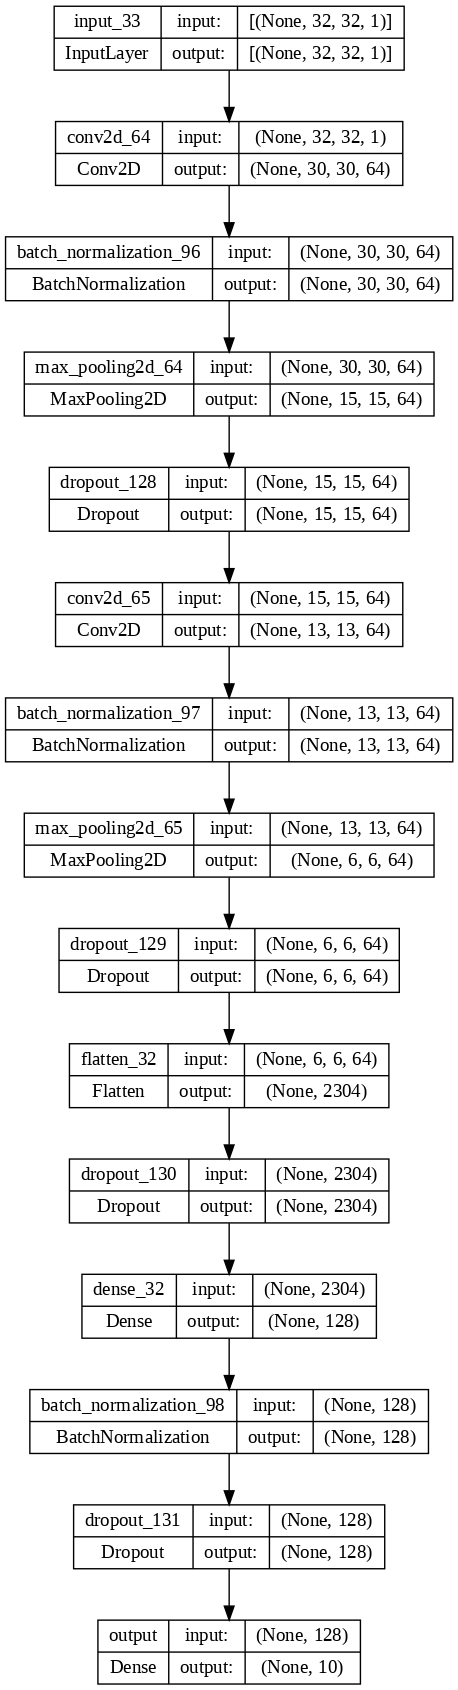

In [ ]:
from tensorflow.keras import utils
utils.plot_model(network_adam, show_shapes=True, dpi=100)

In [ ]:
from IPython import display
import time

# training phase
def train_network(network, x_training, y_training, x_validation, y_validation, n_epoch, batch_size, network_filepath):

    # lists where we will be storing values during training, for visualization purposes
    tra_losses = [] # list for training loss
    tra_accs = [] # list for training accuracy
    val_losses = [] # list for validation loss
    val_accs = [] # list for validation accuracy

    # we want to save the parameters that give the best performance on the validation set
    # therefore, we store the best validation accuracy, and save the parameters to disk
    best_validation_accuracy = 0 # best validation accuracy

    for epoch in range(n_epoch):
        st = time.time()

        # Train
        results = network.fit(x_training, y_training, batch_size=batch_size)

        # training loss and accuracy
        training_loss = results.history['loss']
        training_accuracy = results.history['sparse_categorical_accuracy']

        #
        tra_losses.append(training_loss)
        tra_accs.append(training_accuracy)

        # Evaluate performance (loss and accuracy) on validation set
        scores = network.evaluate(x=x_validation, y=y_validation, batch_size=1)
        validation_loss = scores[0]
        validation_accuracy = scores[1]

        # Add to list
        val_losses.append(validation_loss)
        val_accs.append(validation_accuracy)

        # (Possibly) update best validation accuracy and save the network
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            network.save(network_filepath)

        # Visualization of the learning curves
        fig = plt.figure(figsize=(10, 5))
        tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b')
        tra_accs_plt, = plt.plot(range(len(tra_accs)), tra_accs, 'c')
        val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'm')
        val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend([tra_loss_plt, tra_accs_plt, val_loss_plt, val_acc_plt],
                  ['training loss', 'training accuracy', 'validation loss', 'validation accuracy'],
                  loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_validation_accuracy))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.2)

In [ ]:
import os

file_dir = './'
network_filepath = os.path.join(file_dir, 'best_model_CNNs_with_adam_optimizer.h5')

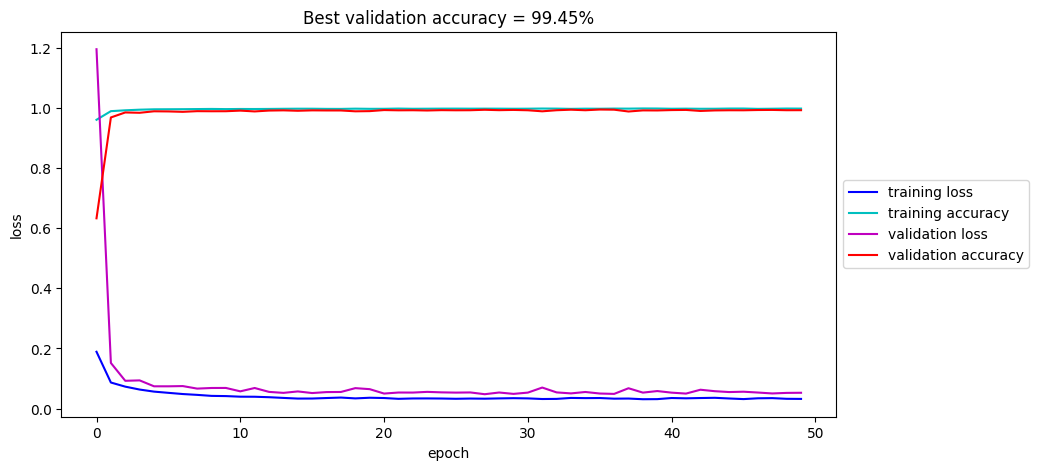

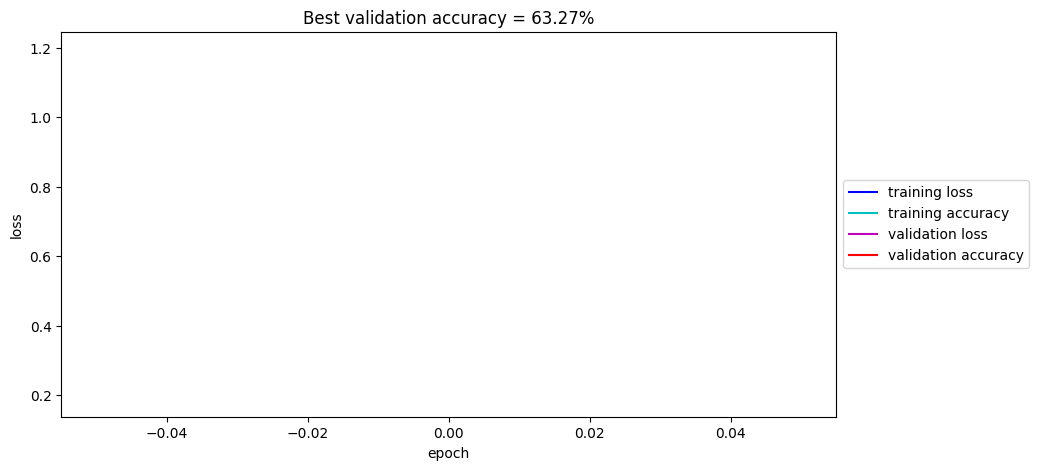

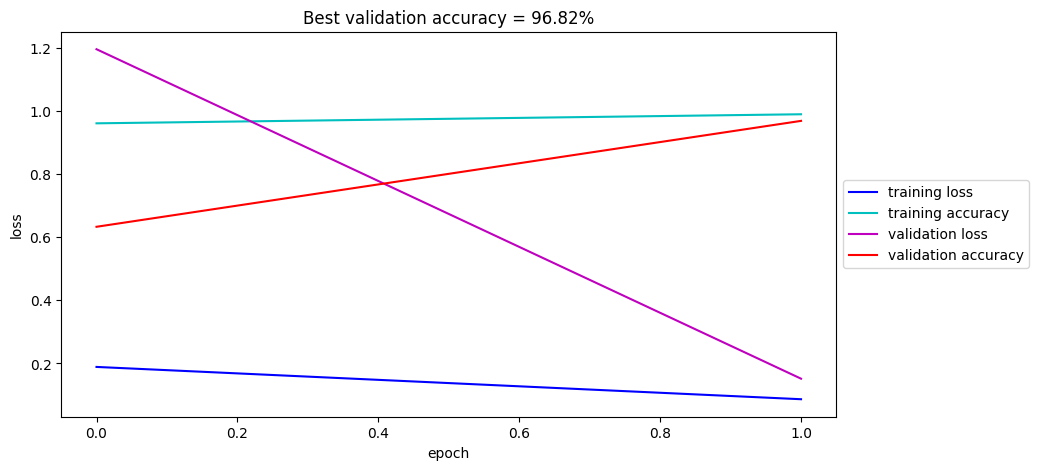

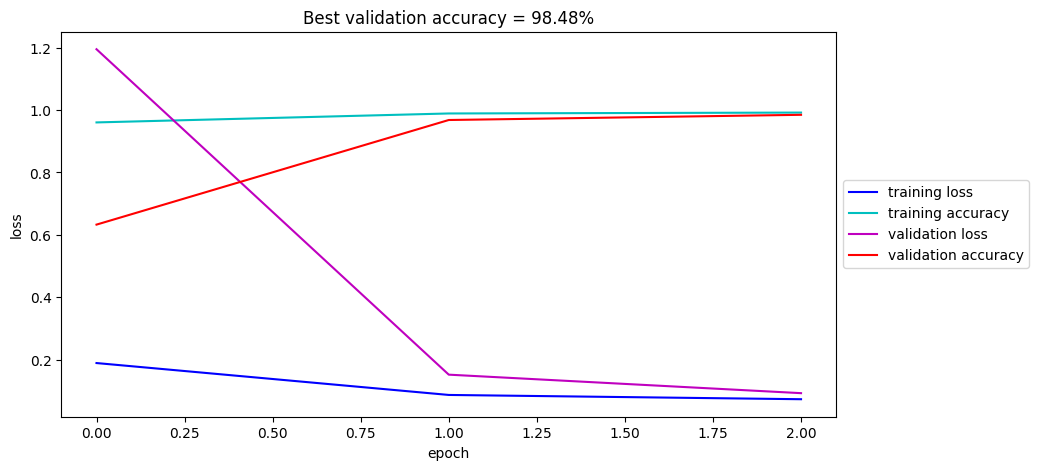

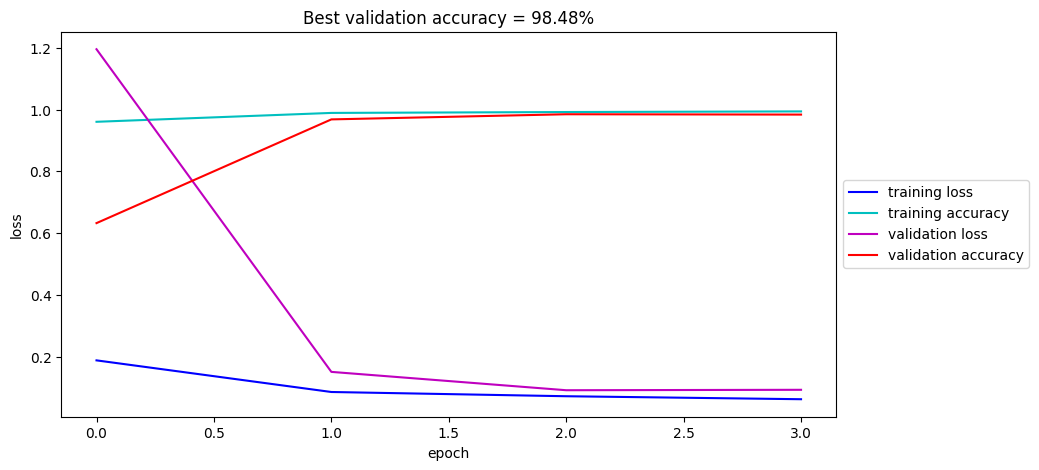

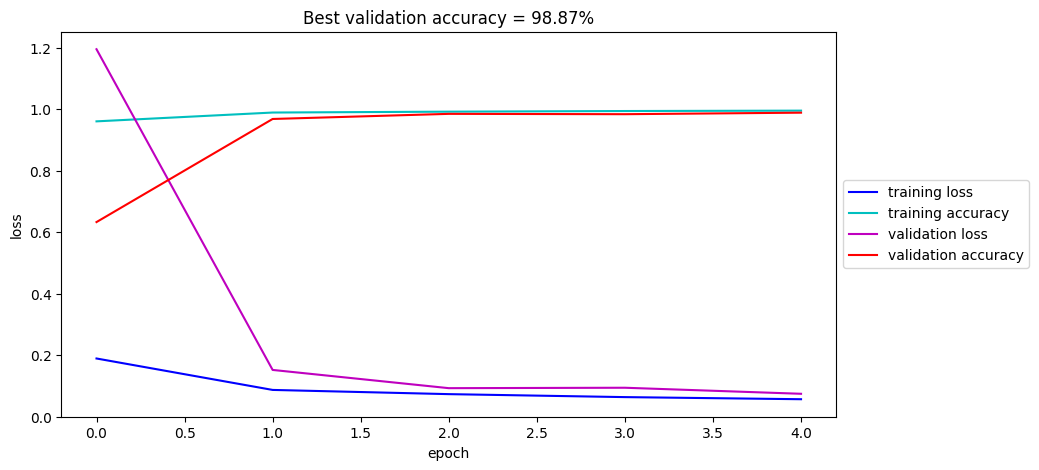

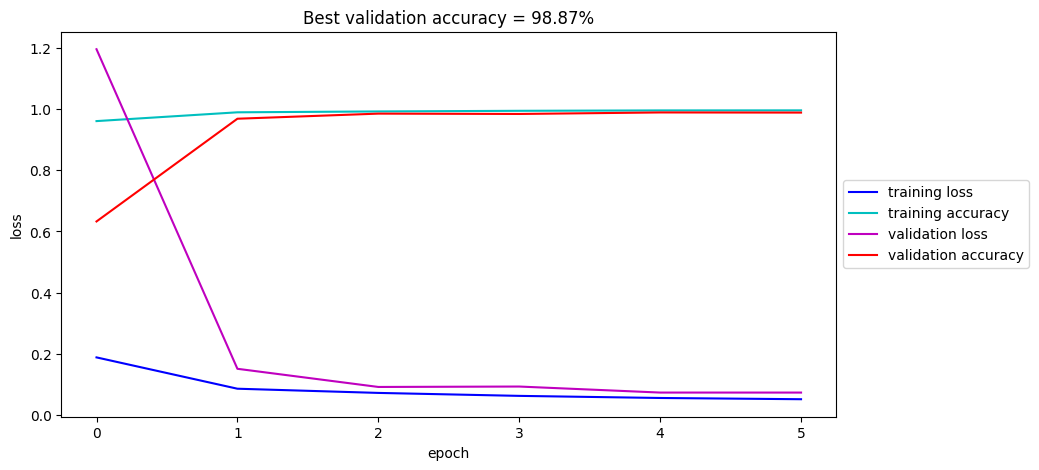

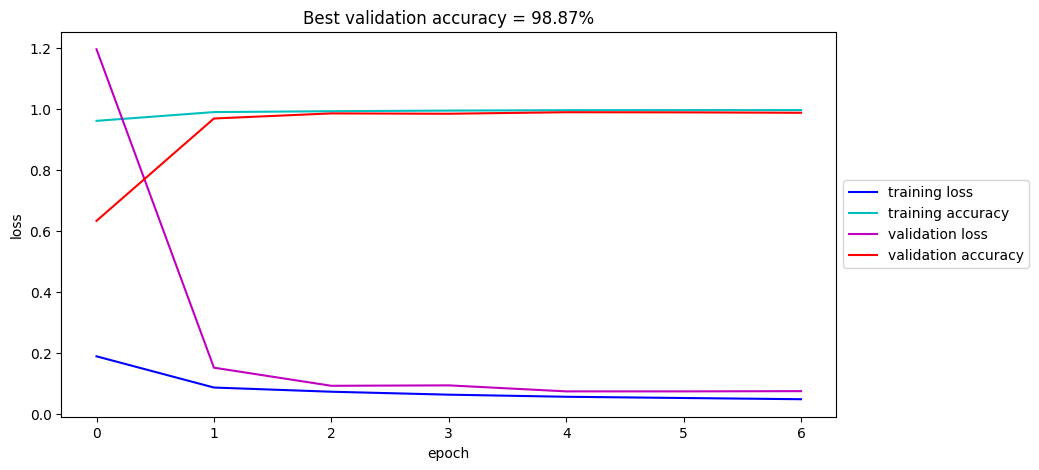

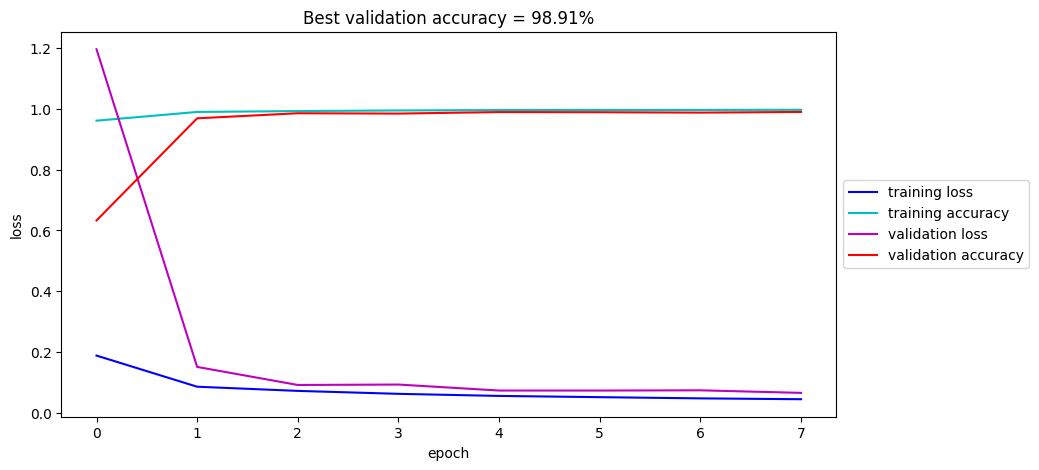

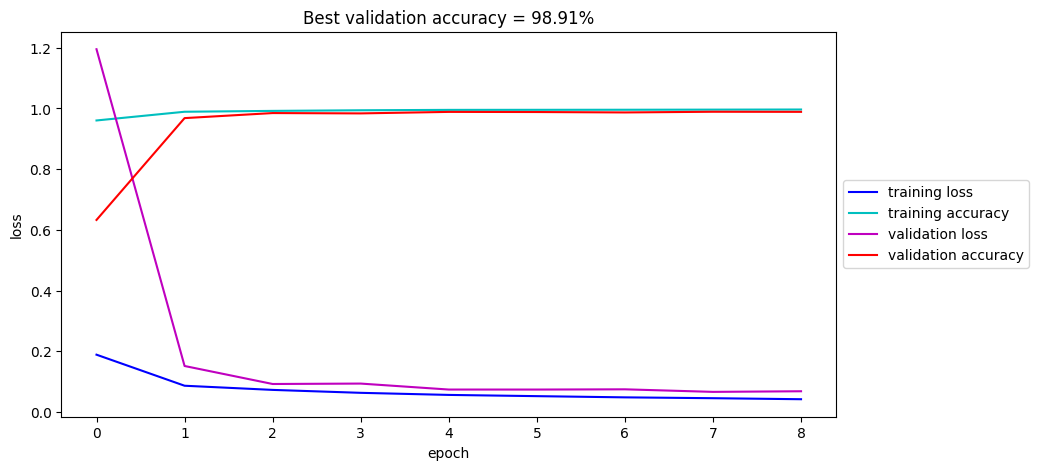

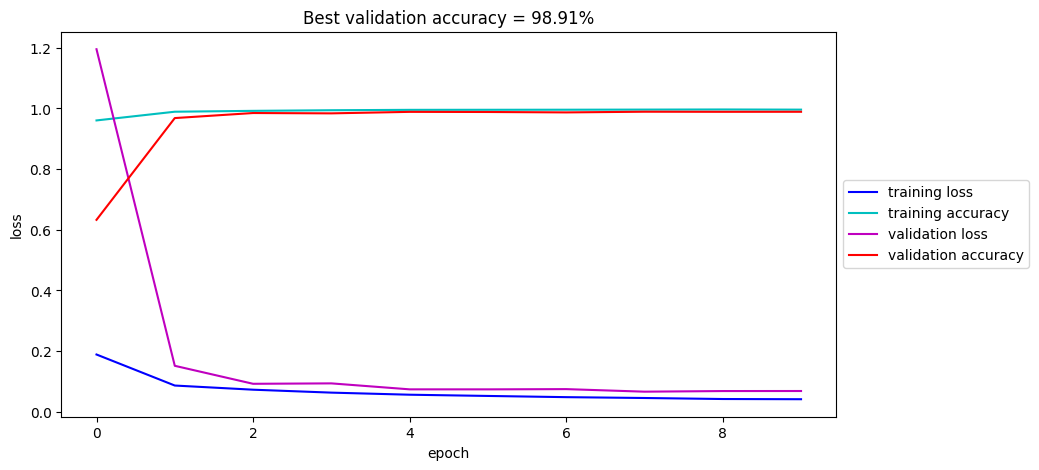

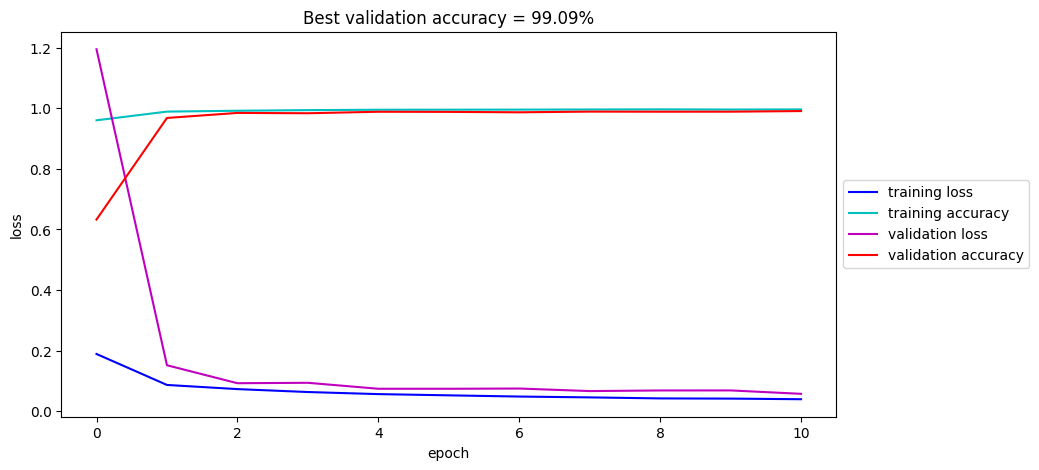

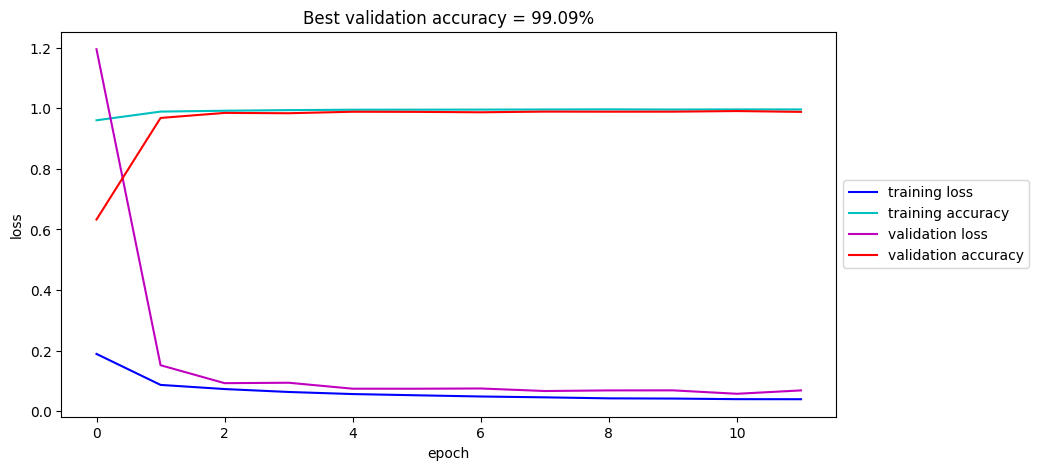

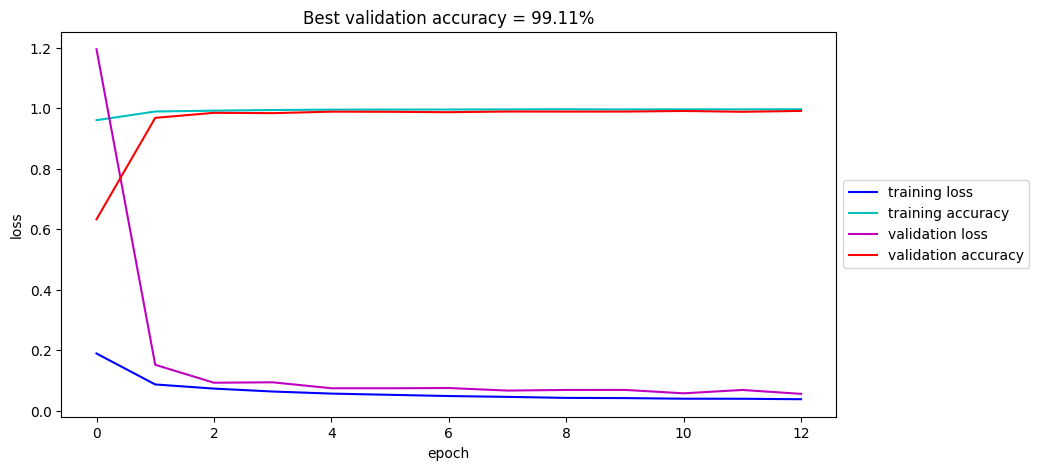

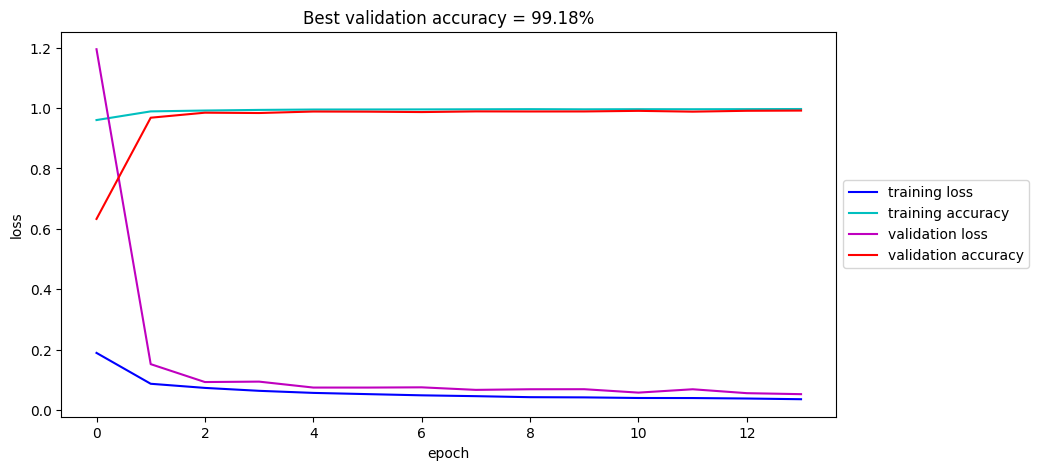

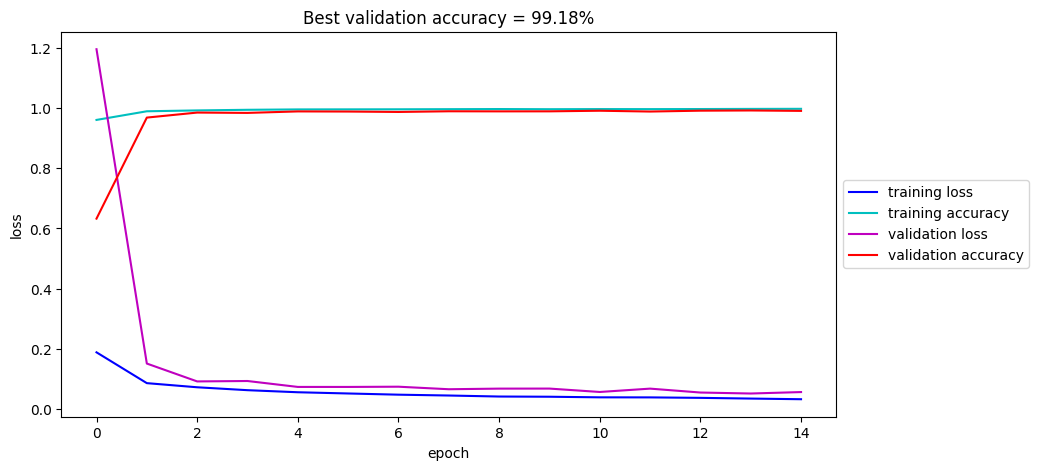

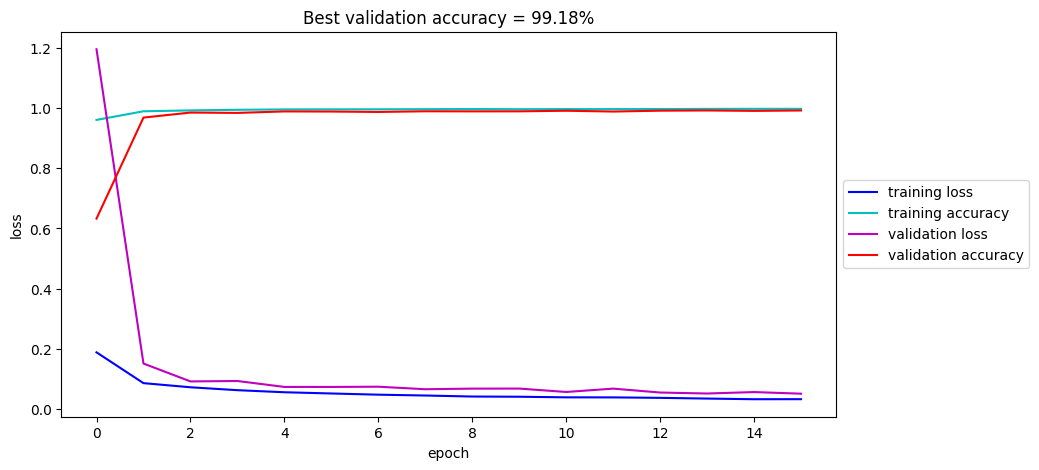

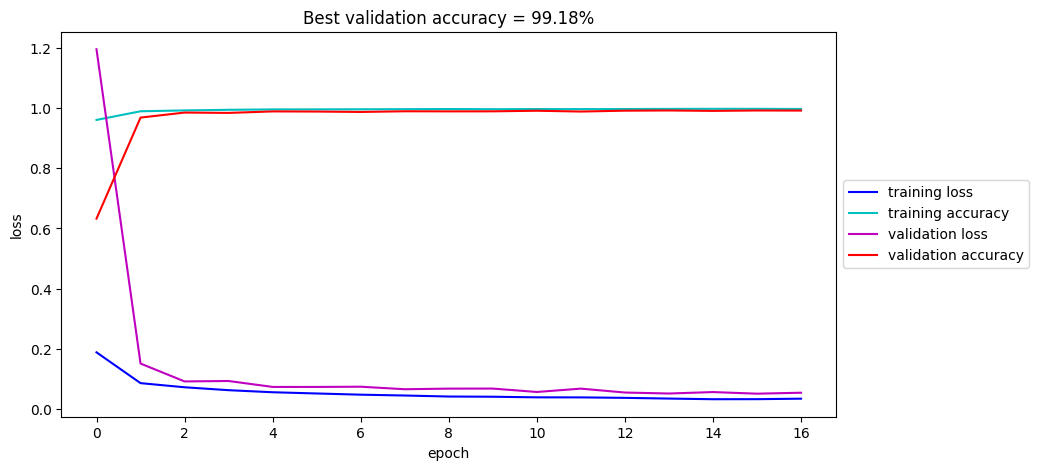

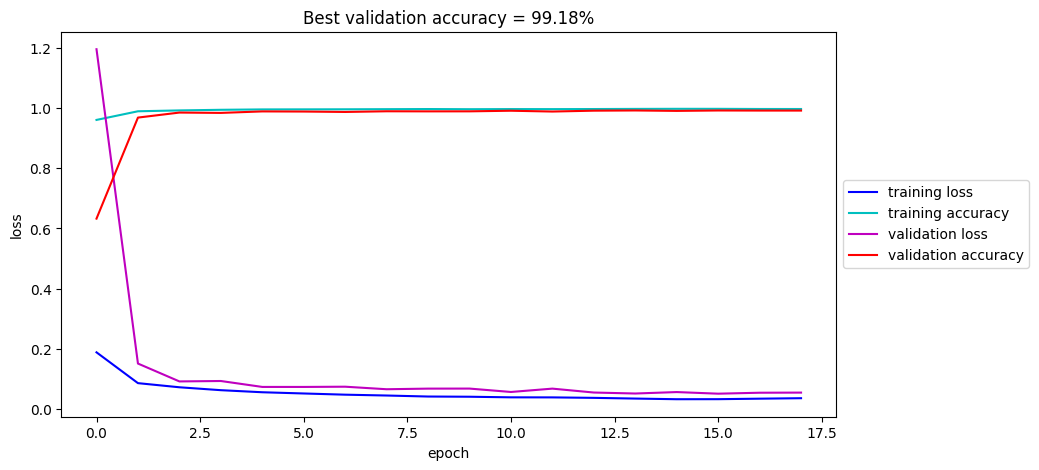

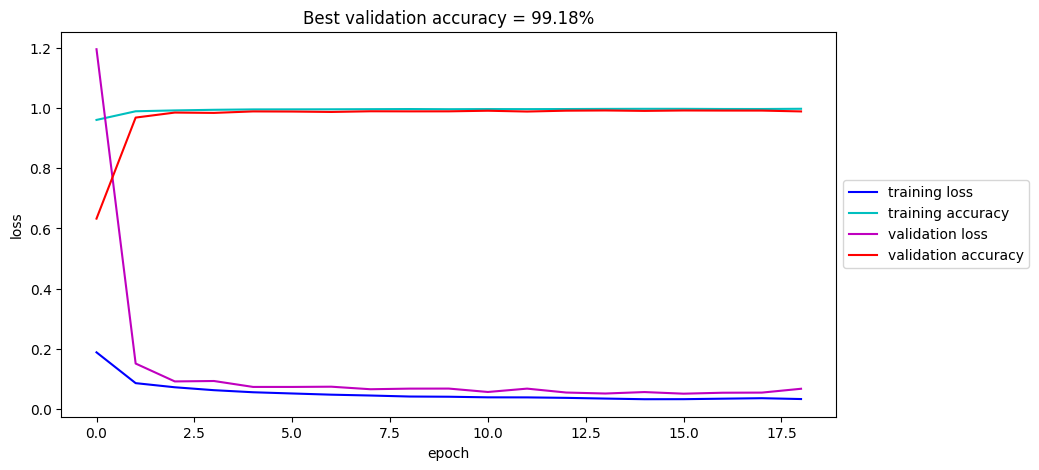

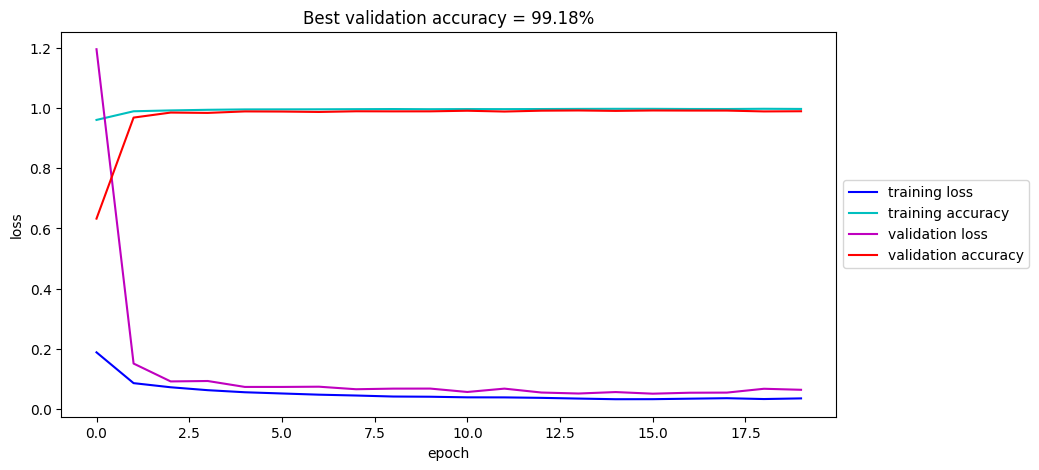

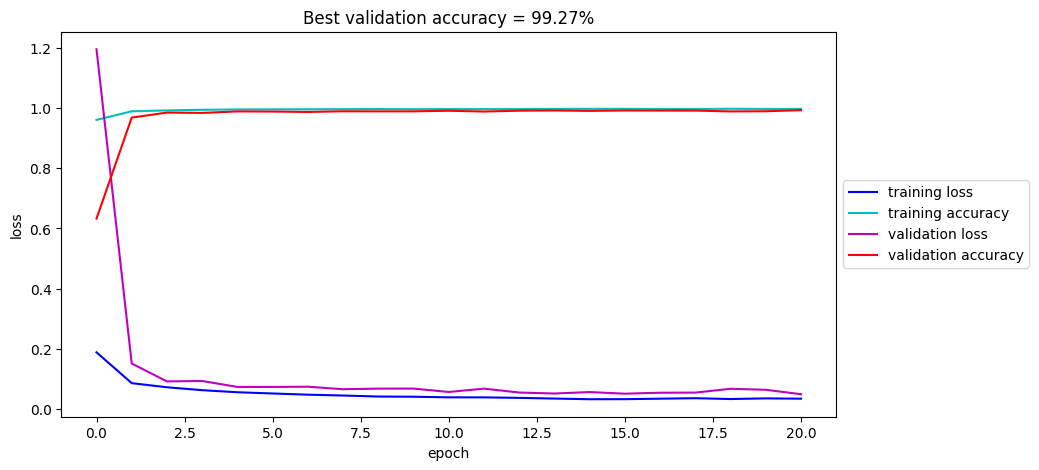

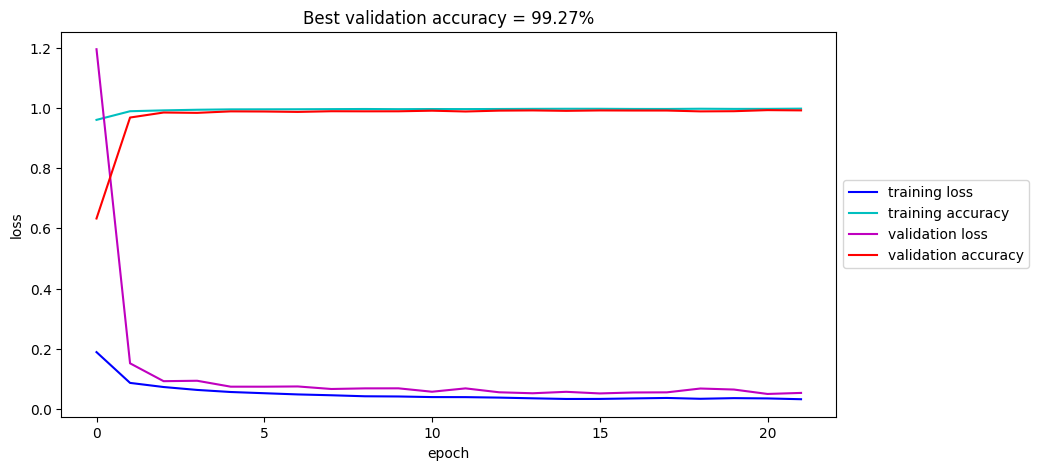

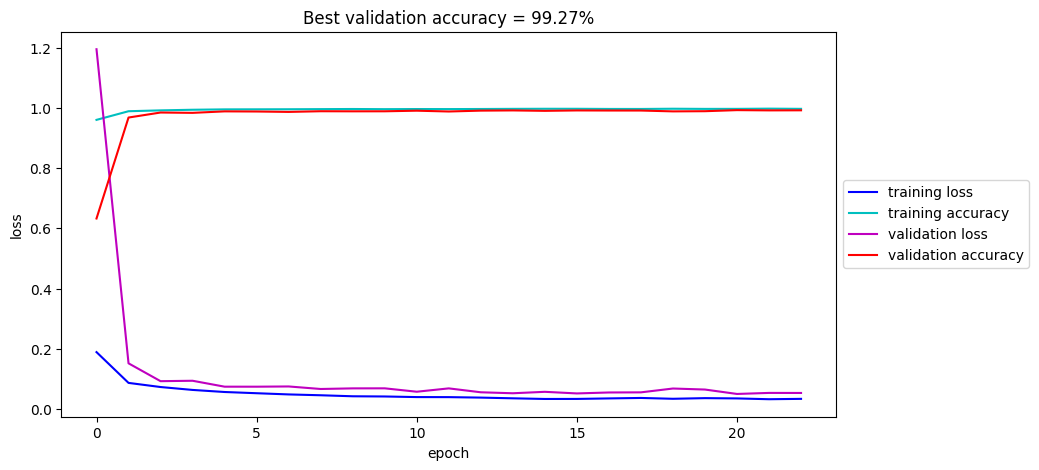

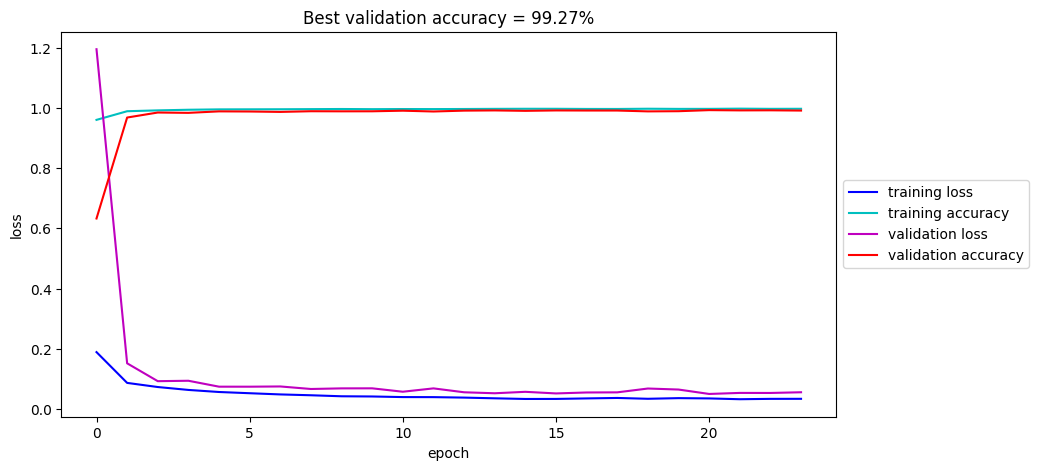

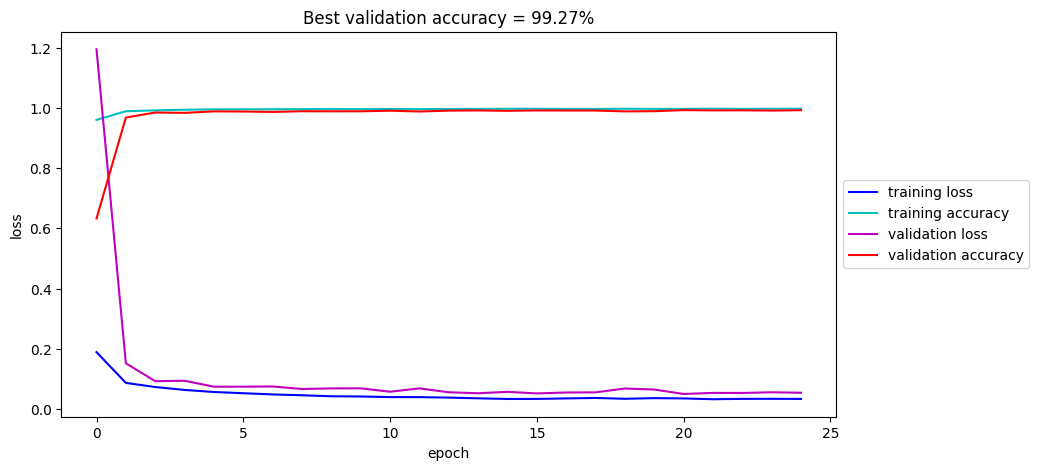

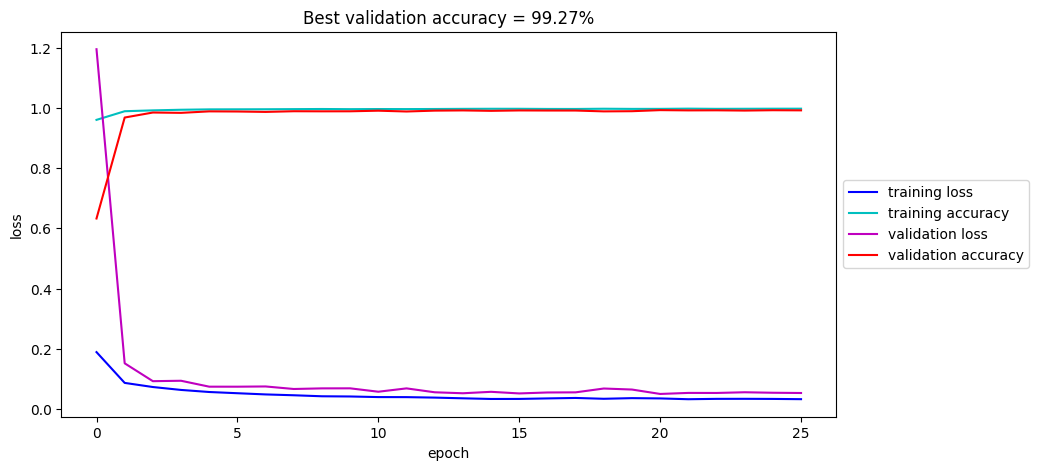

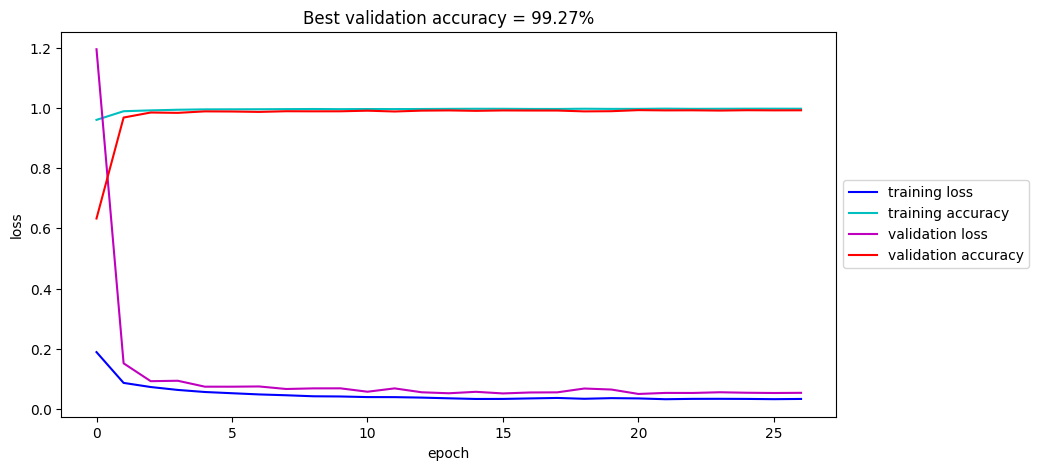

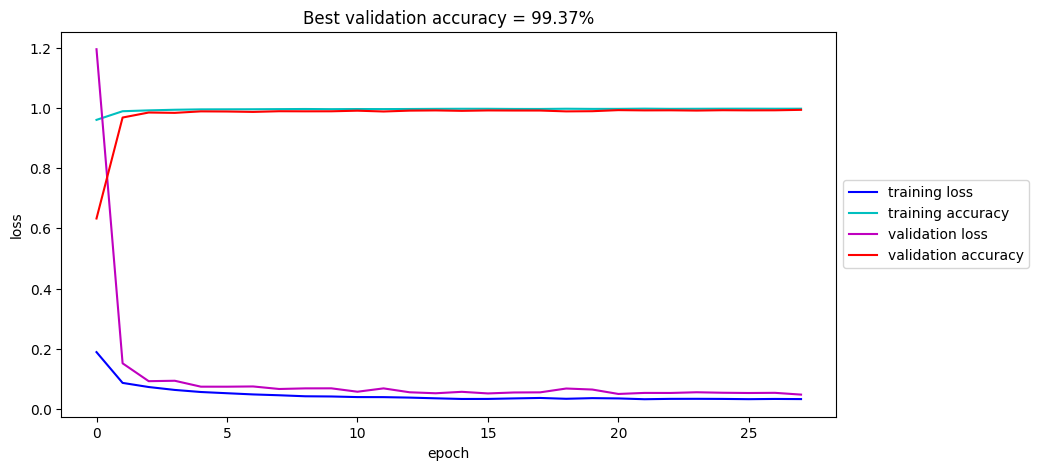

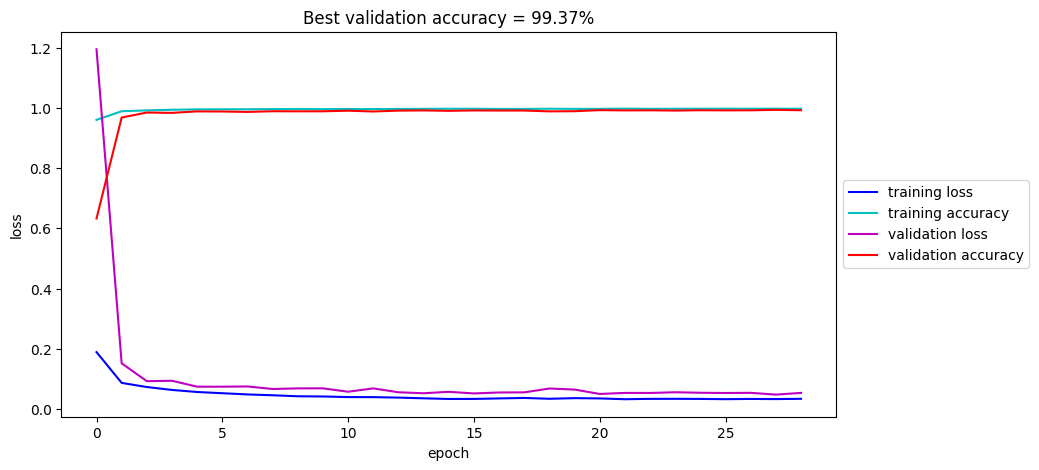

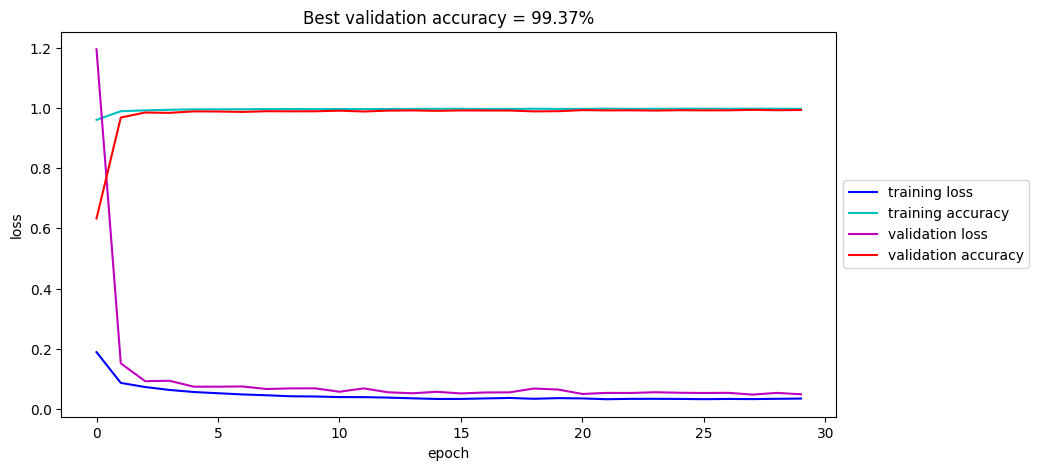

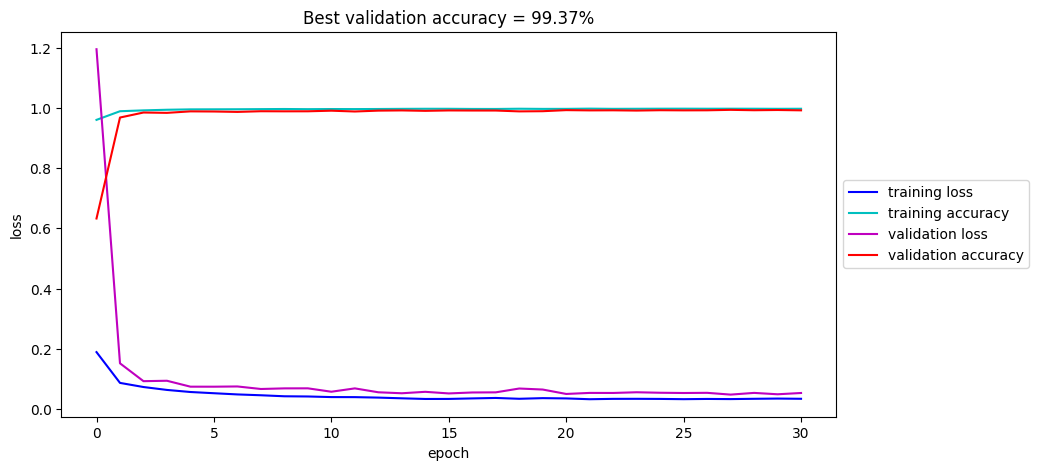

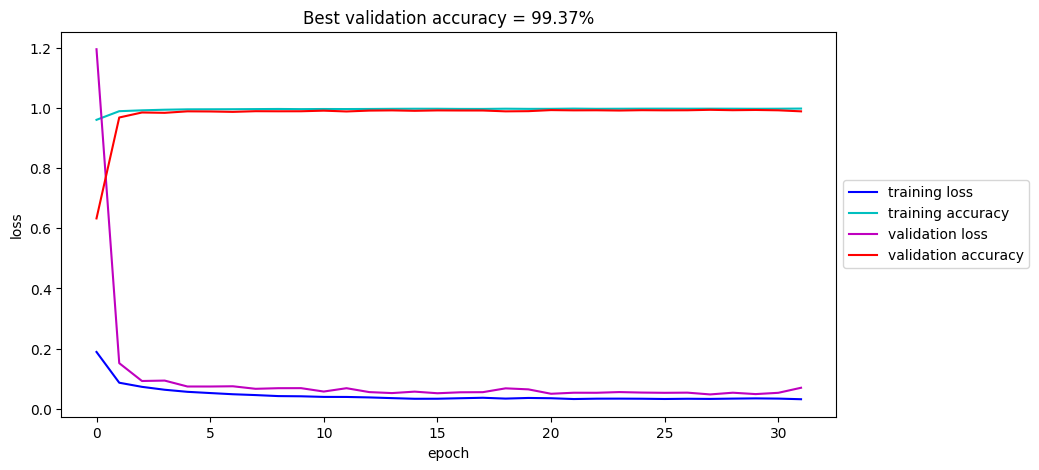

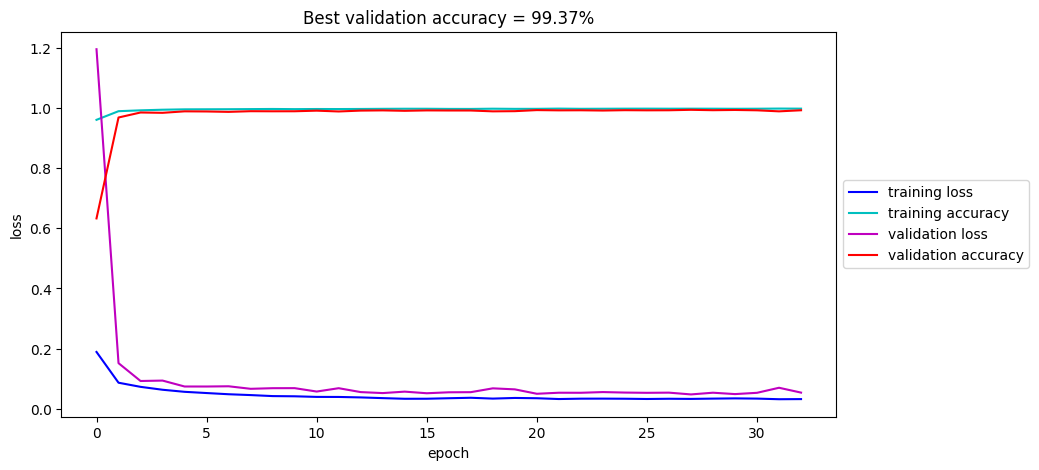

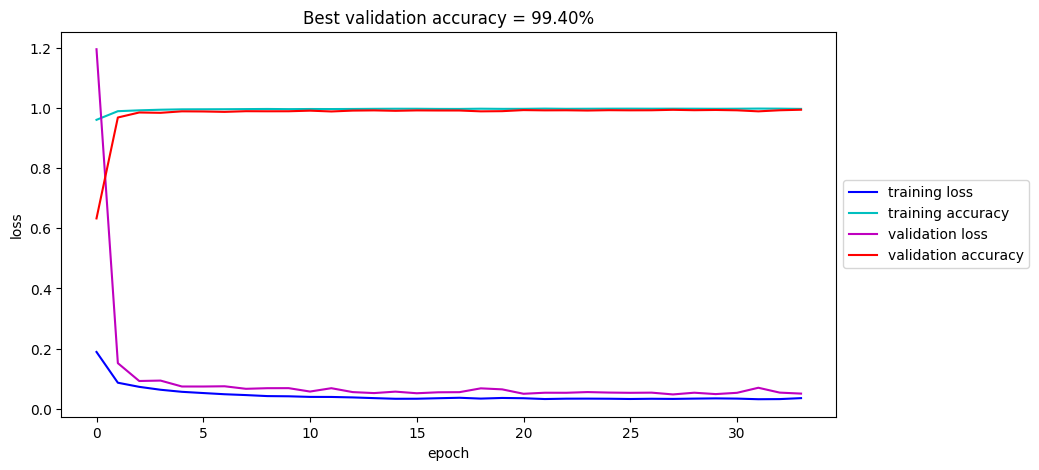

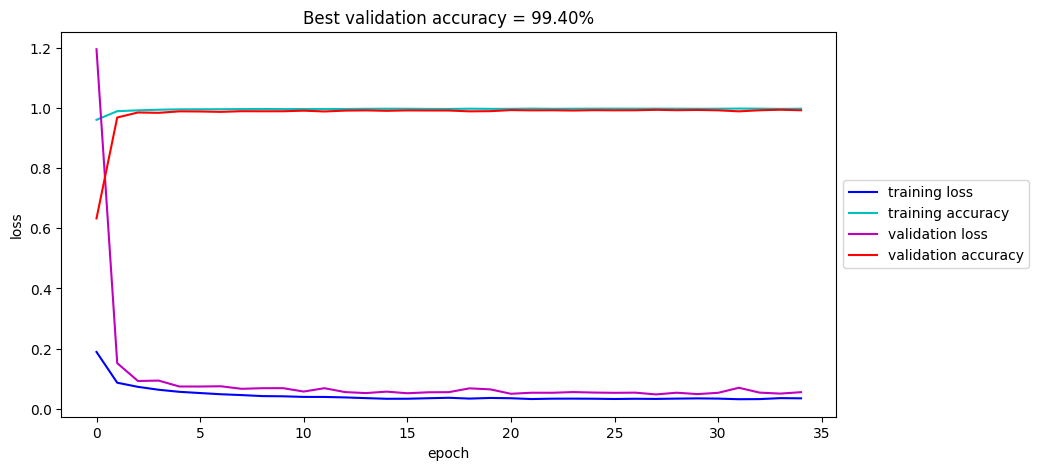

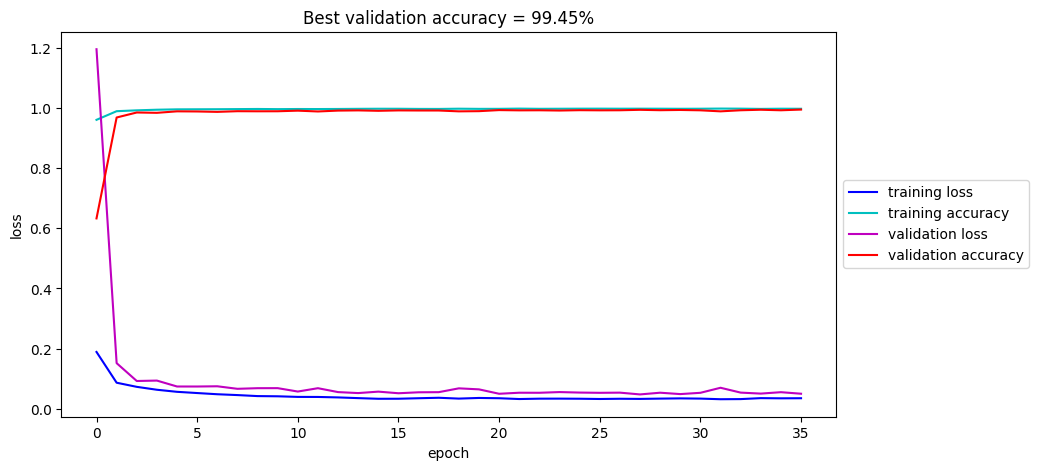

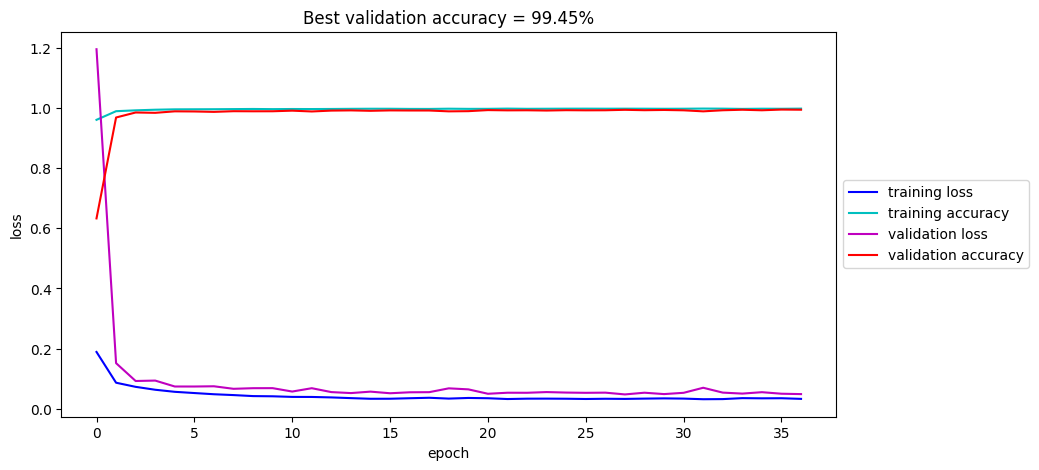

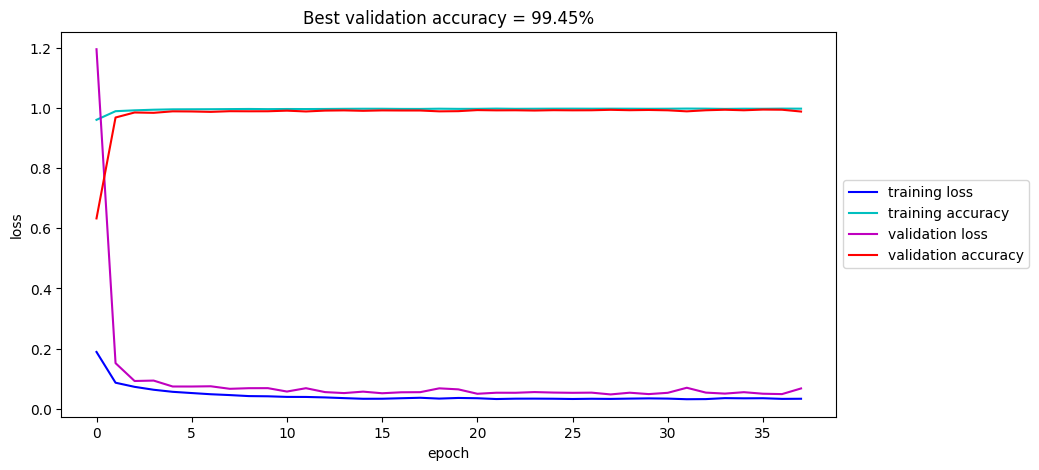

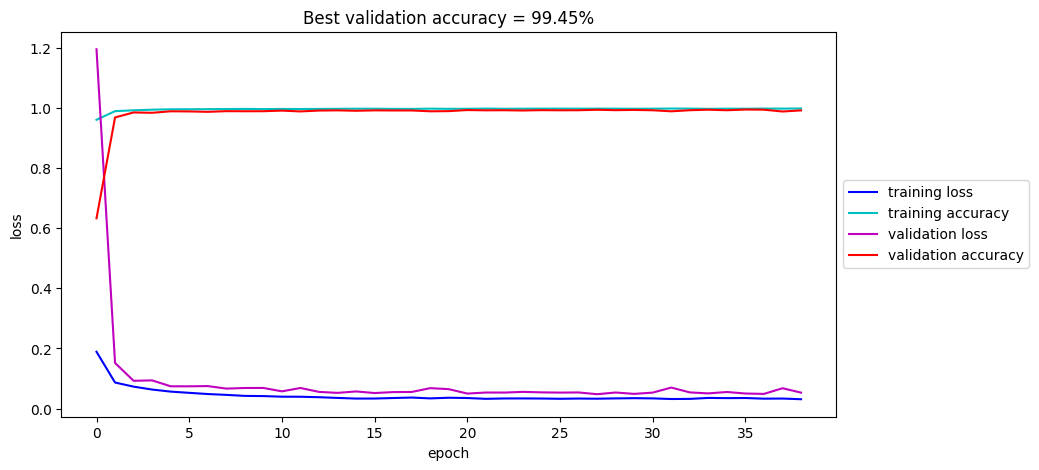

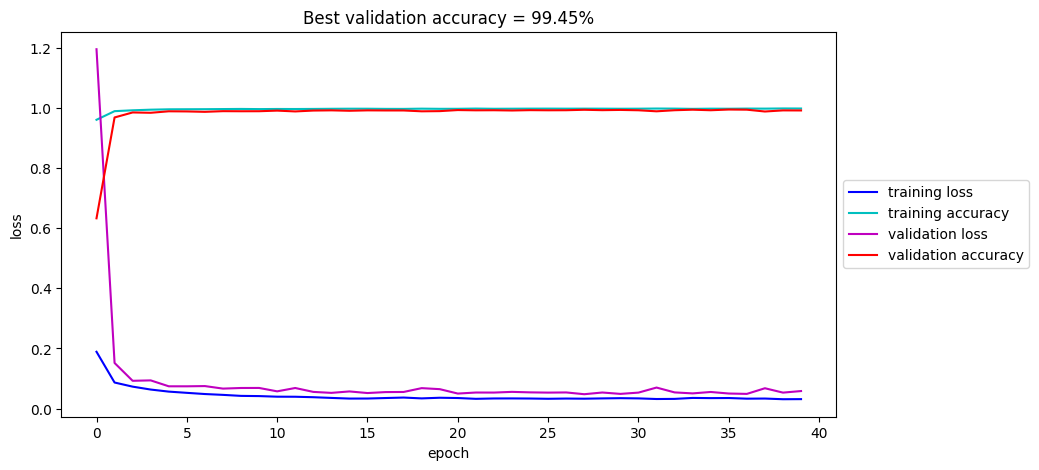

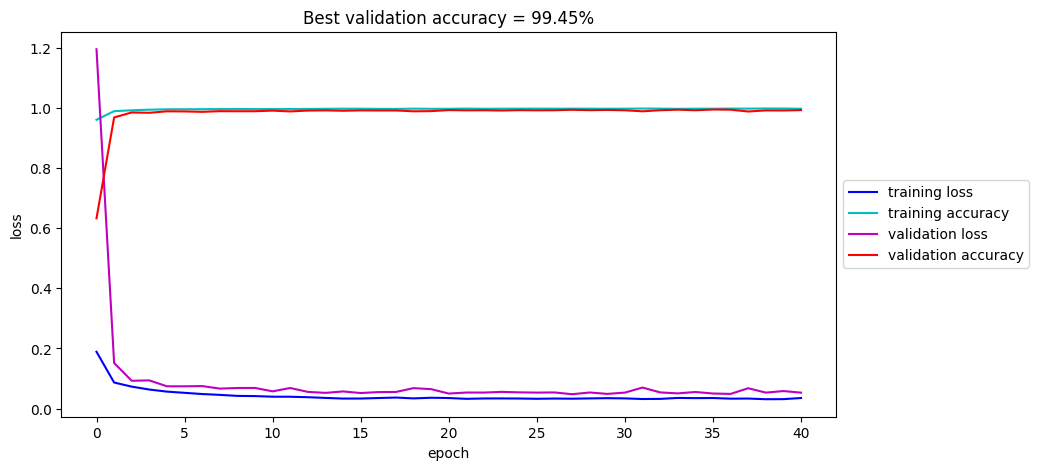

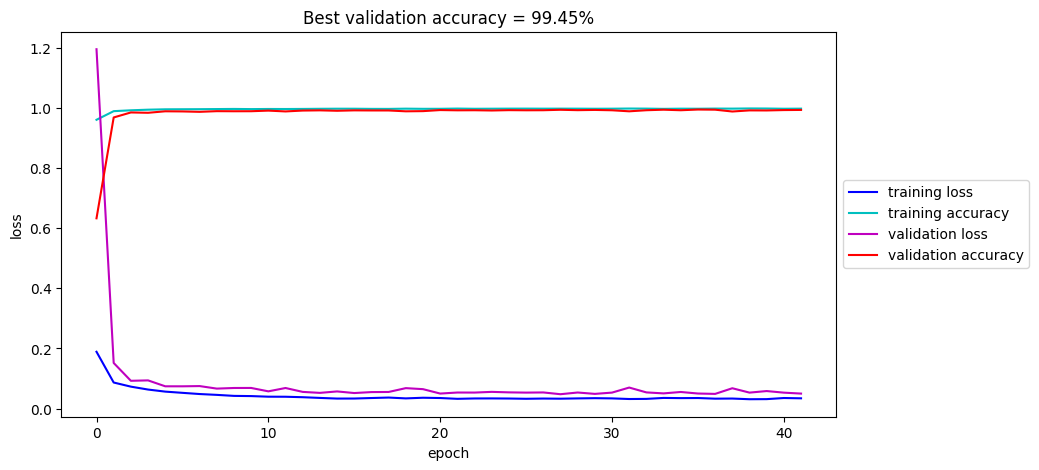

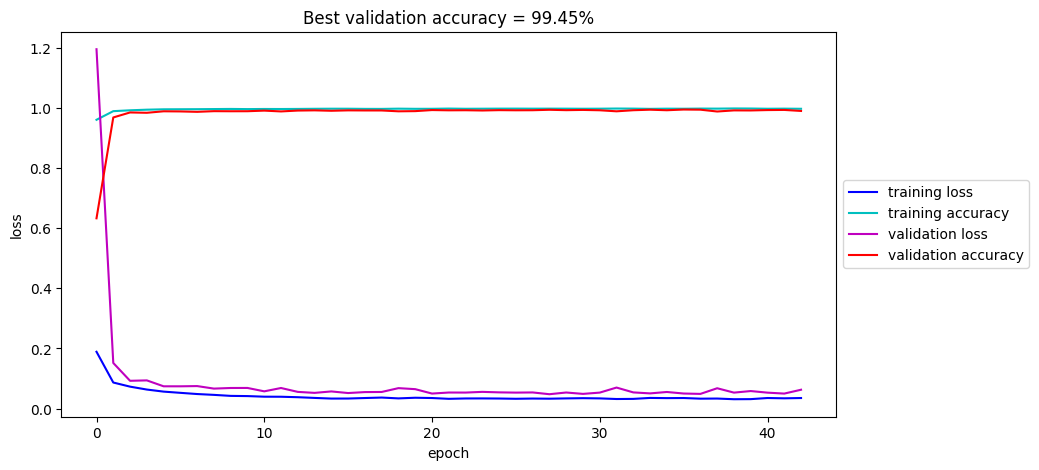

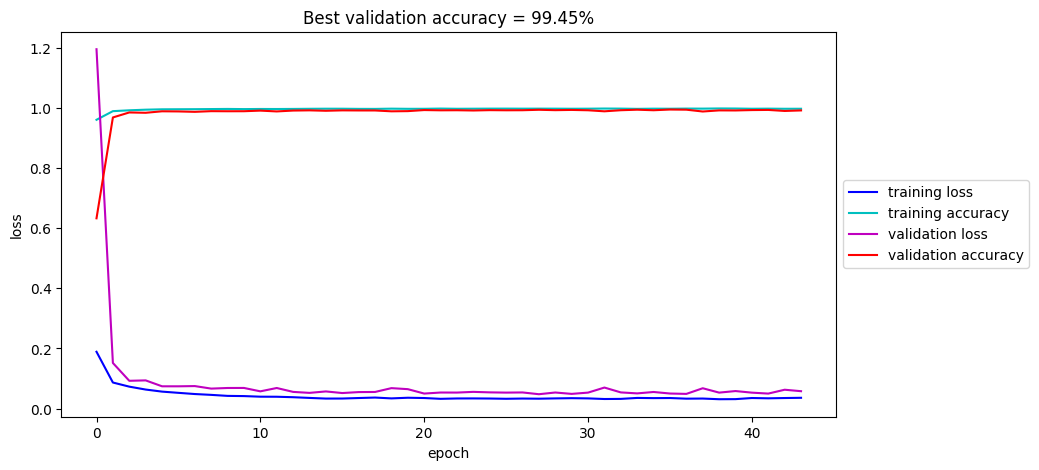

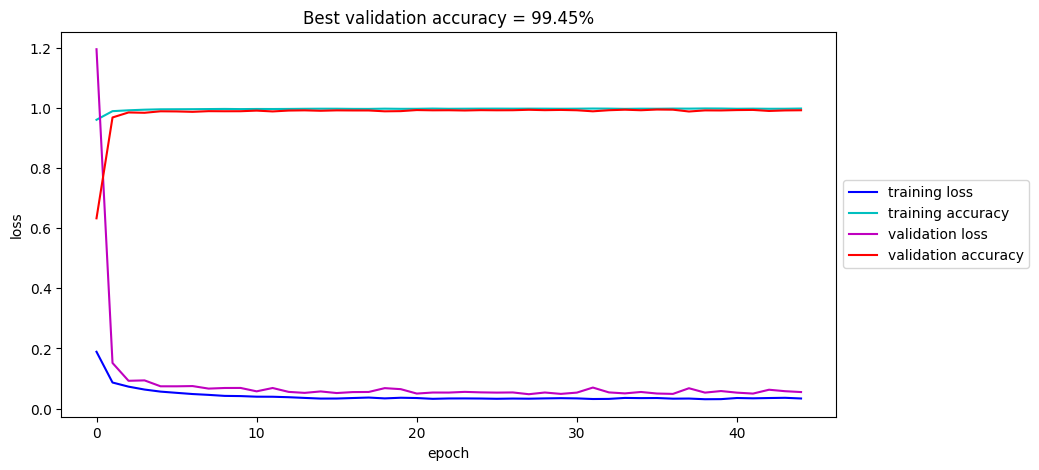

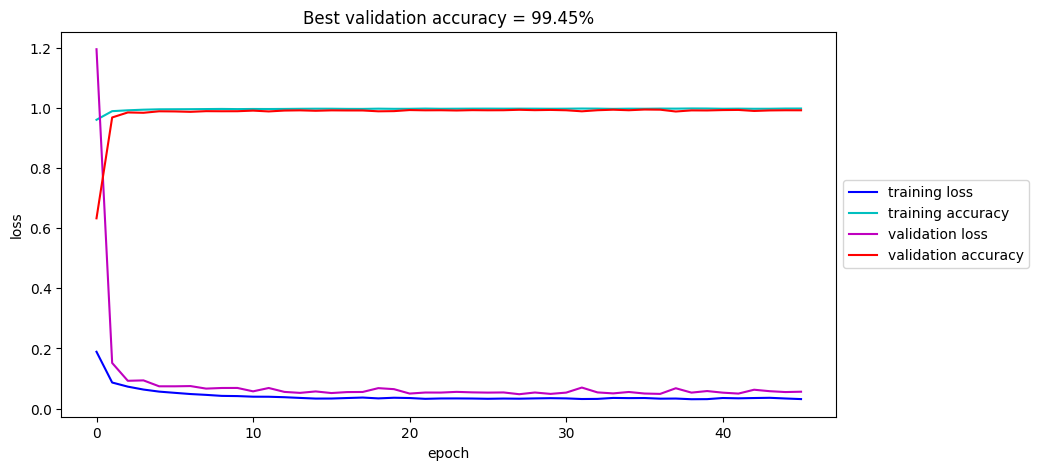

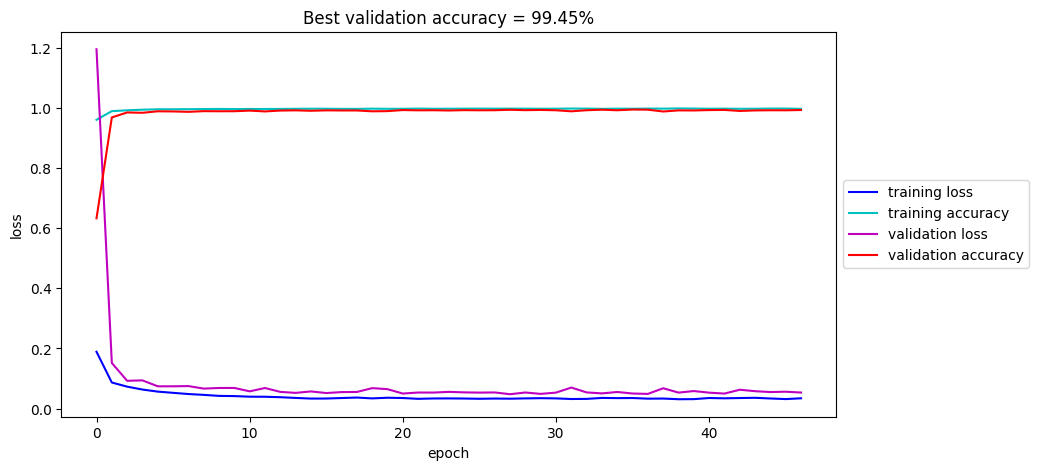

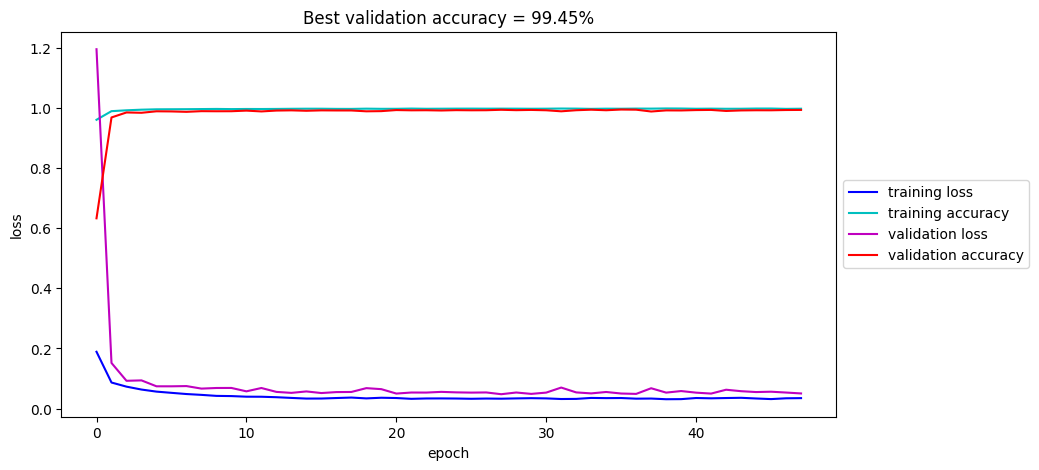

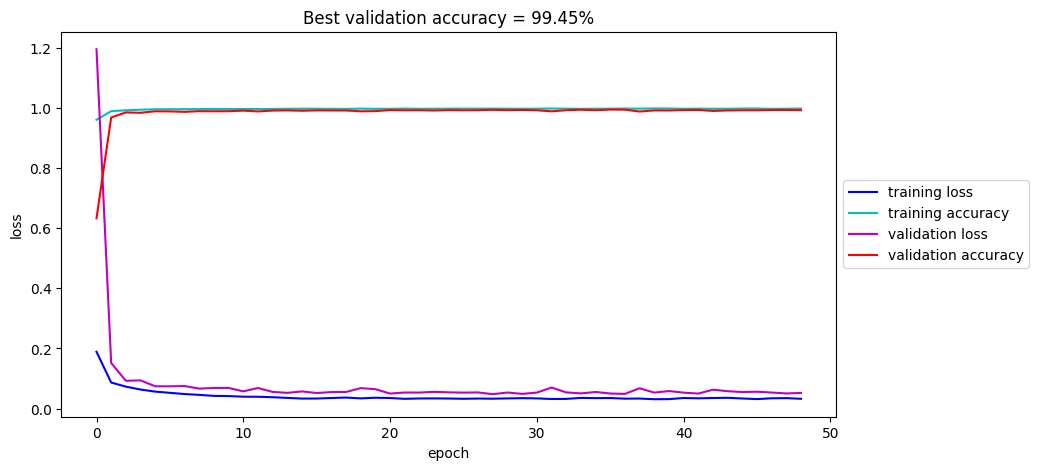

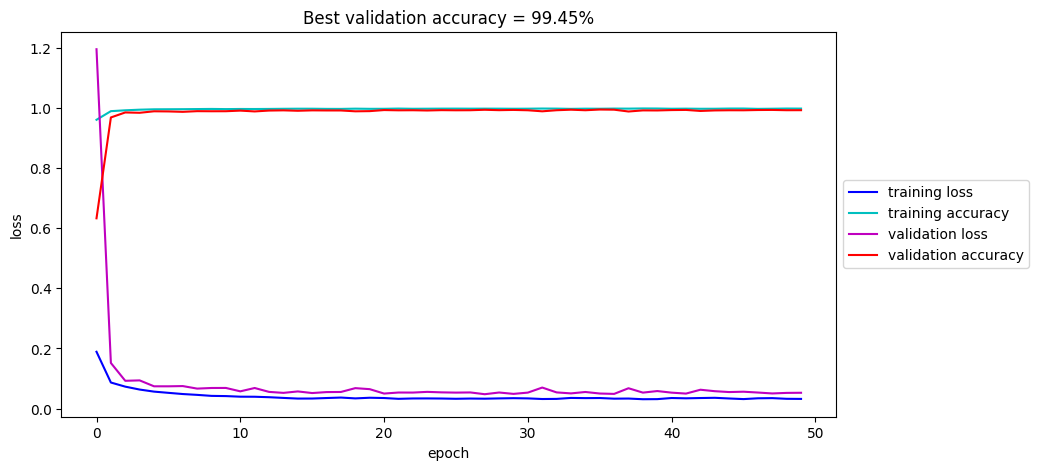

In [ ]:
train_network(network_adam, X_train, y_train,
              X_test, y_test, n_epoch, batch_size, network_filepath)

# Train with SGD optimizer

In [ ]:
# model compile
metric = tf.keras.metrics.SparseCategoricalAccuracy()
opt = tf.keras.optimizers.SGD(learning_rate=0.01) # defult value of LR
loss = tf.keras.losses.SparseCategoricalCrossentropy()
network_sgd = build_neural_network(n_features, n_classes)
network_sgd.compile(loss=loss, optimizer=opt, metrics=metric)

batch_size = 32
n_epoch = 50

In [ ]:
file_dir = './'
network_filepath = os.path.join(file_dir, 'best_model_CNNs_with_sgd_optimizer.h5')

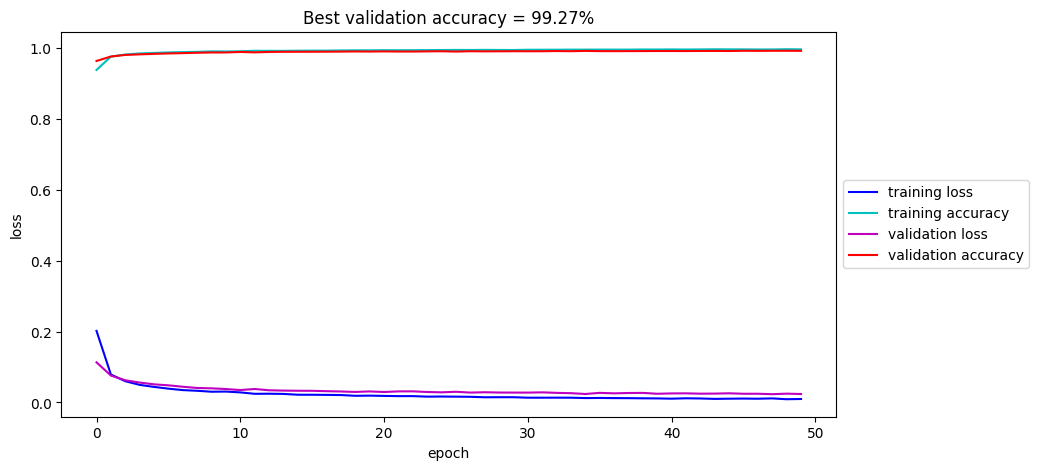

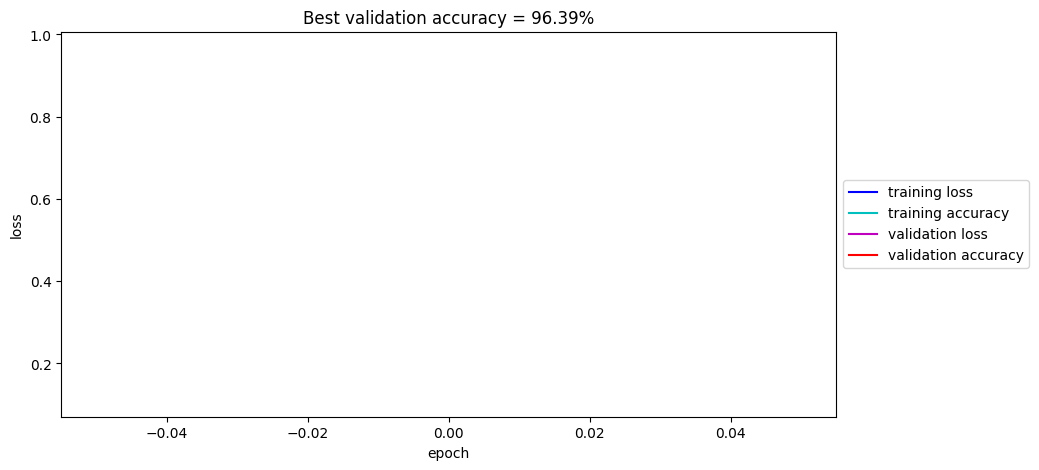

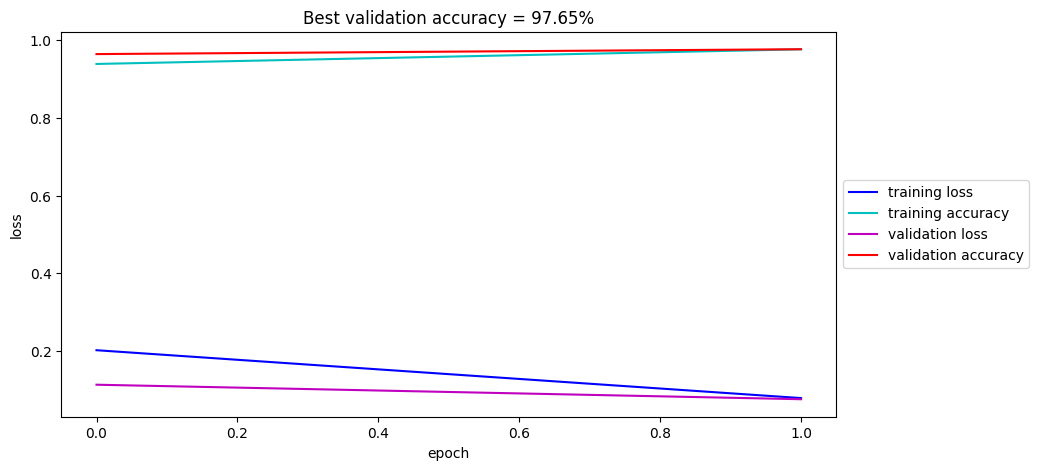

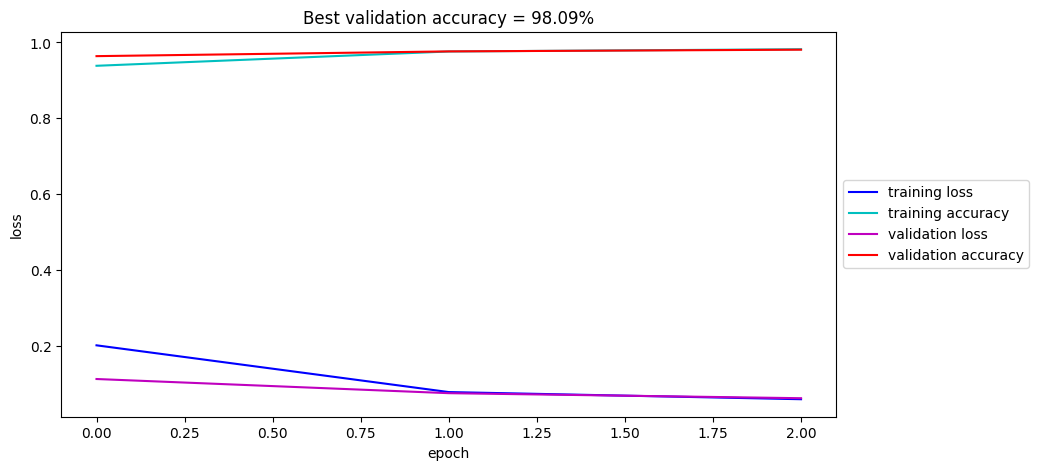

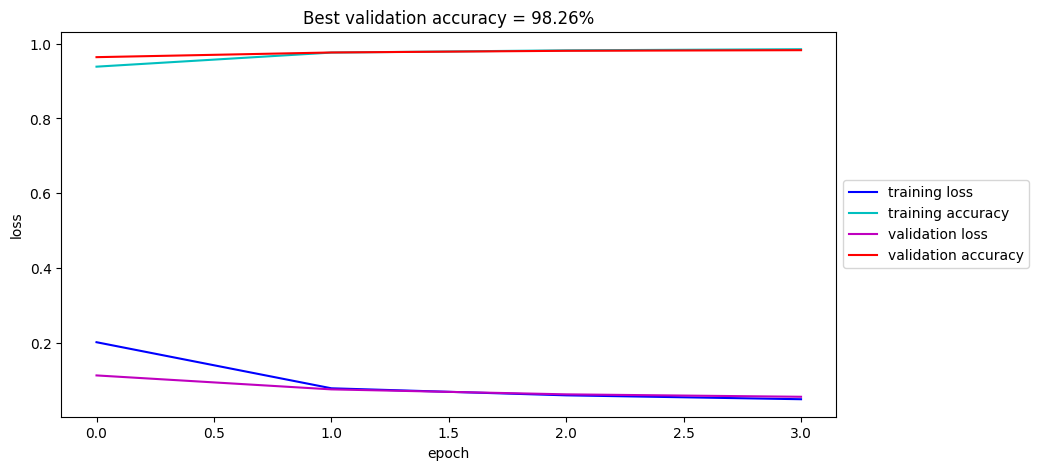

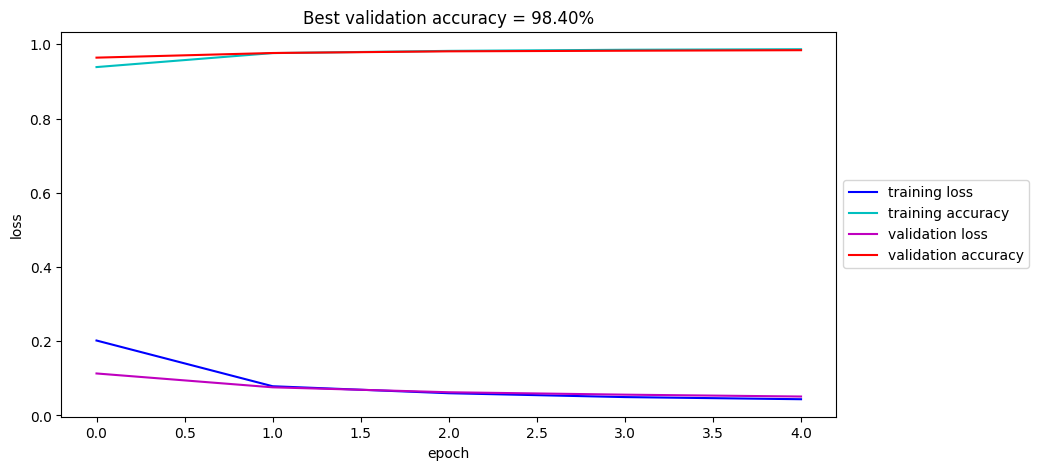

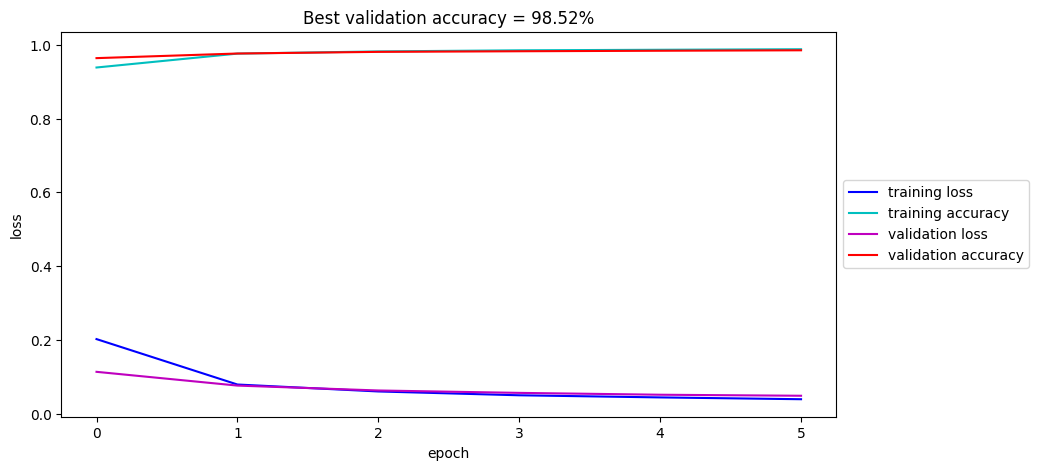

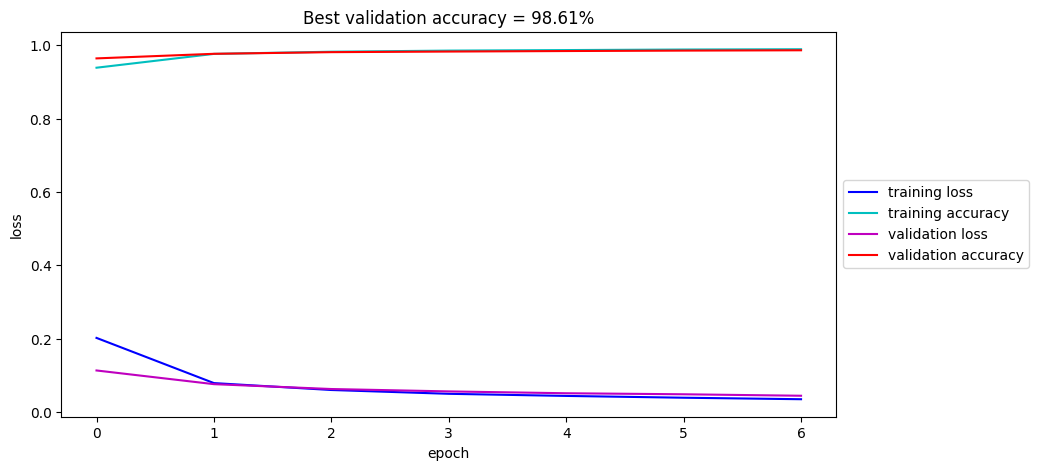

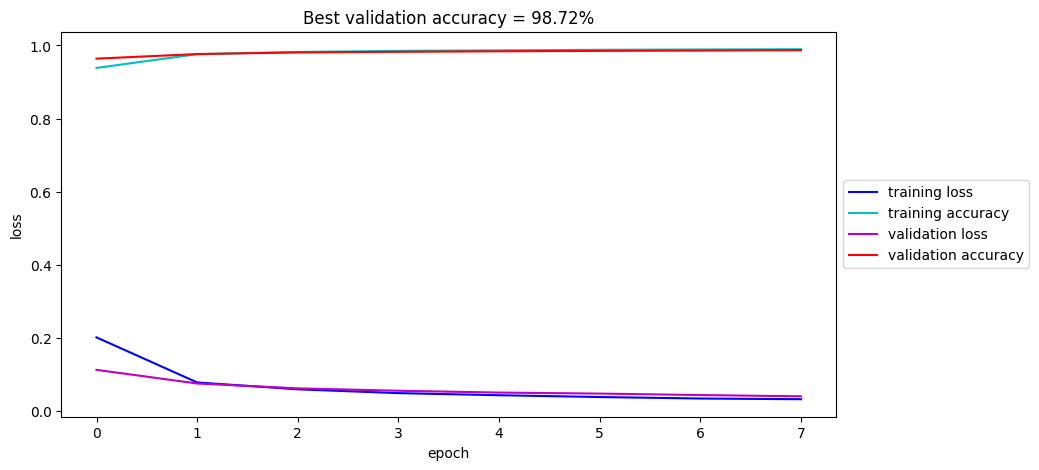

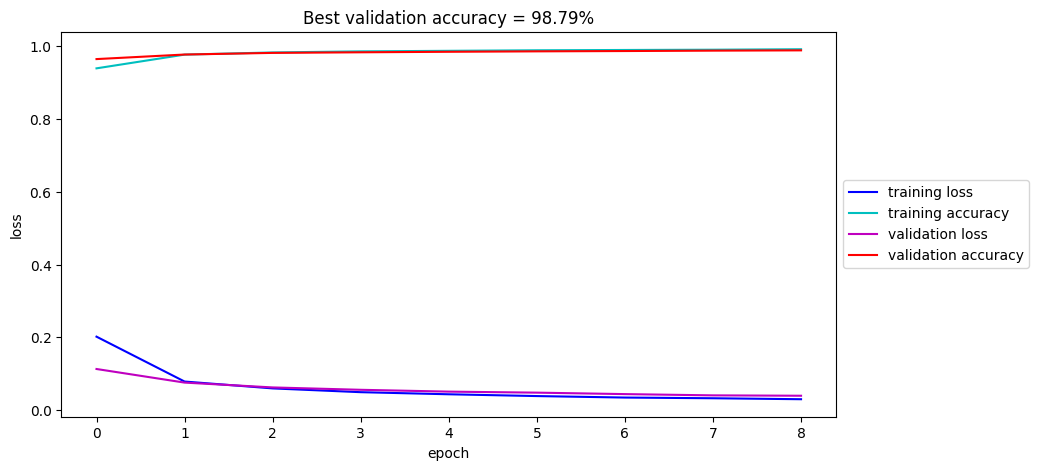

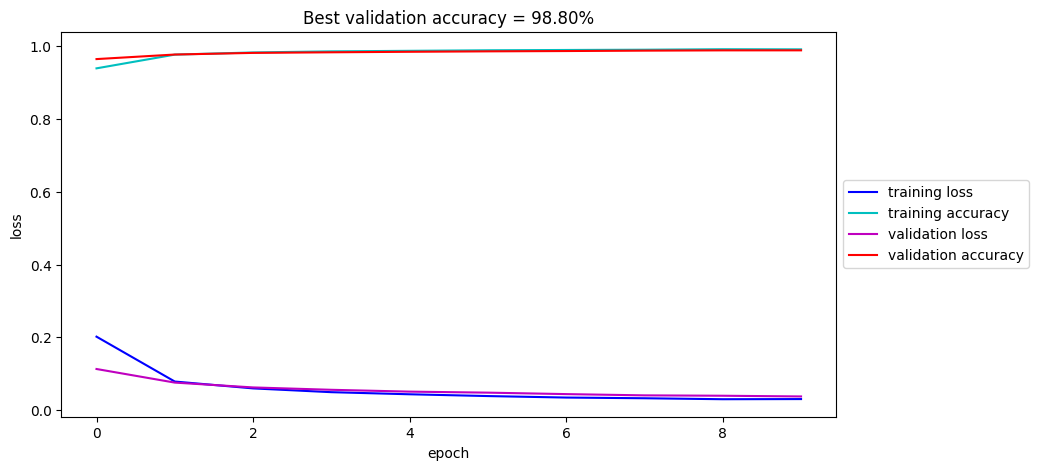

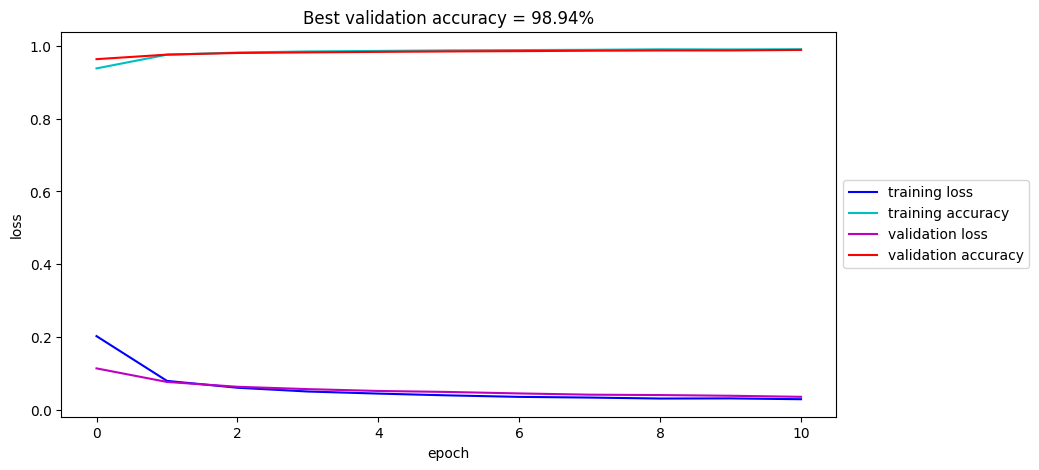

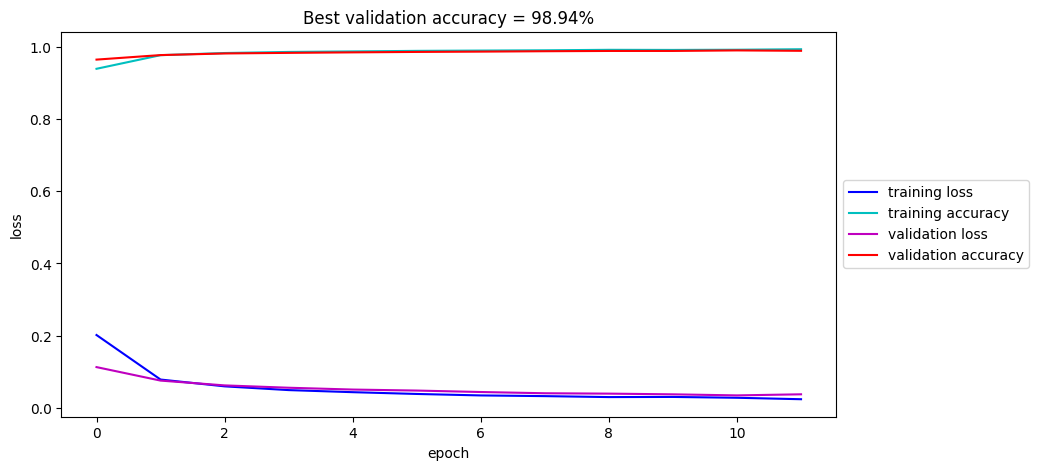

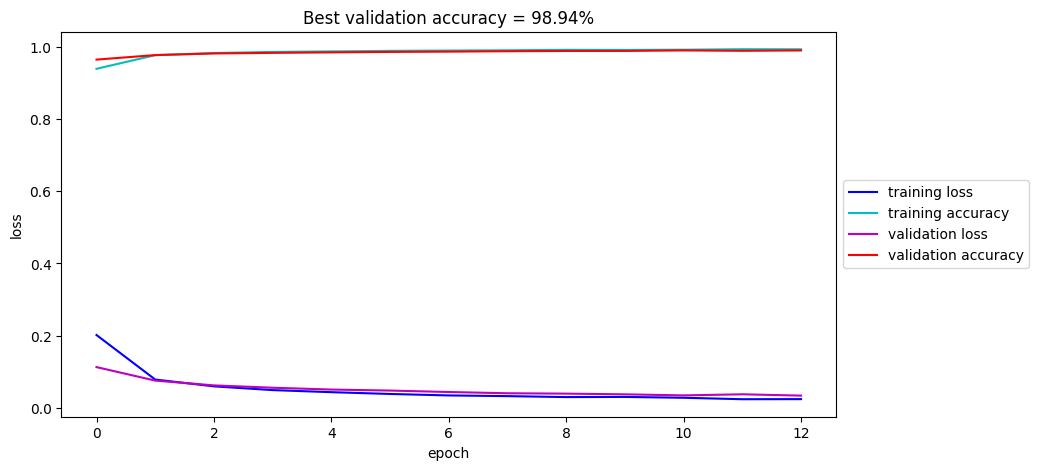

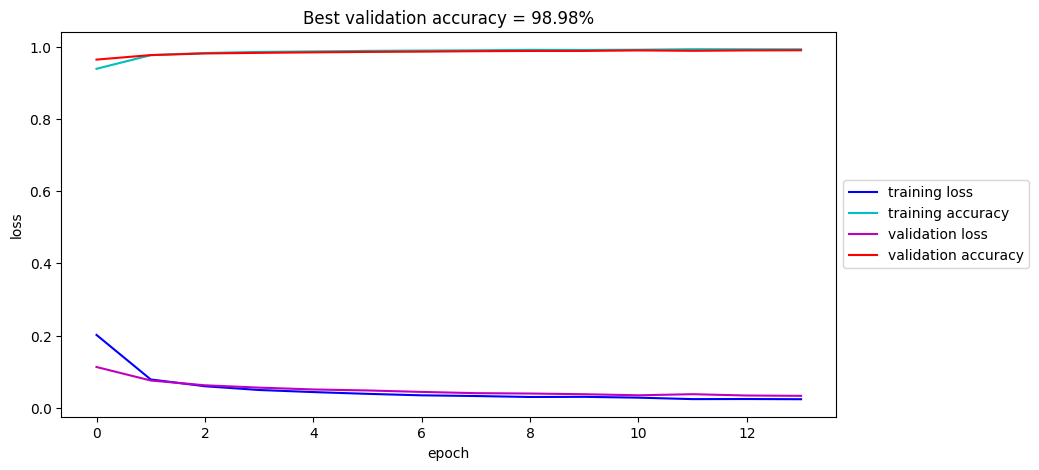

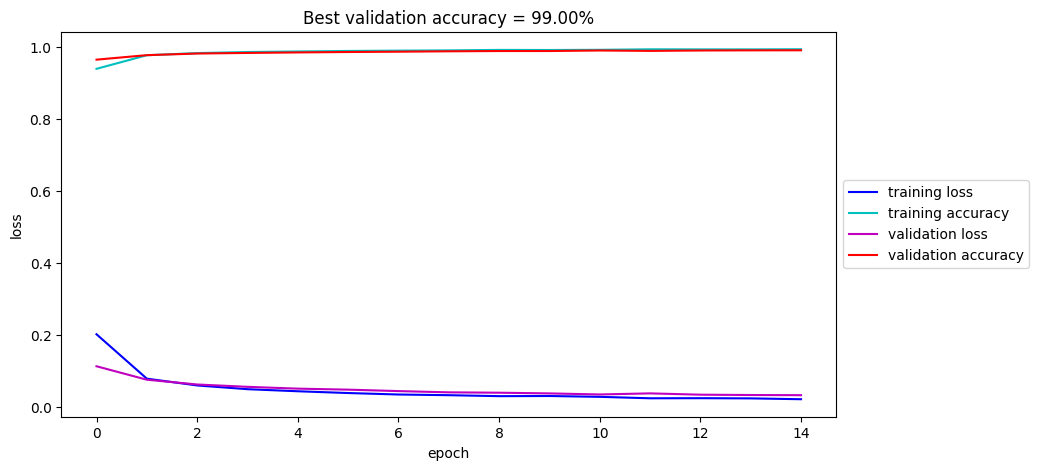

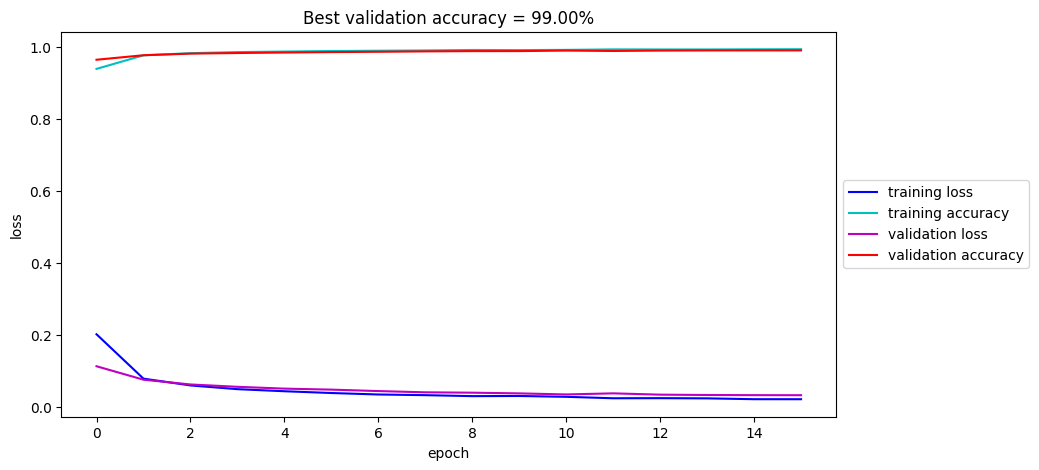

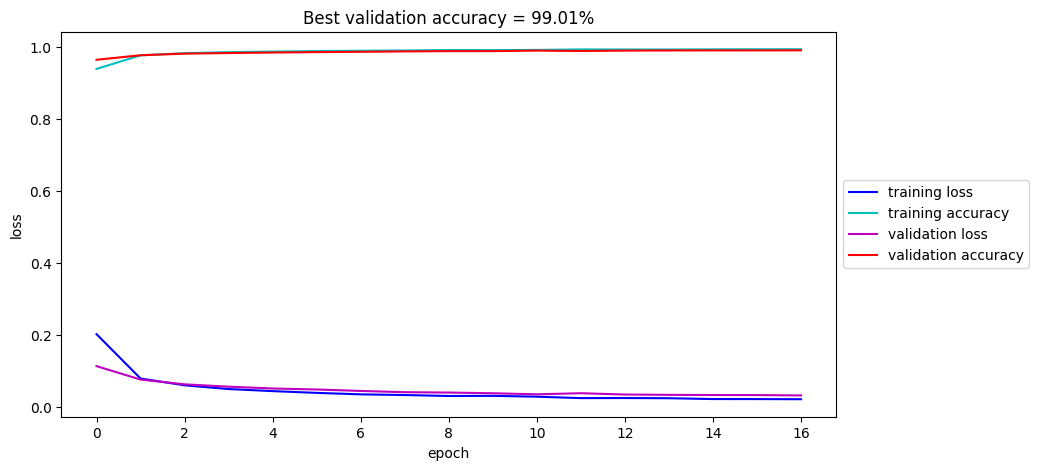

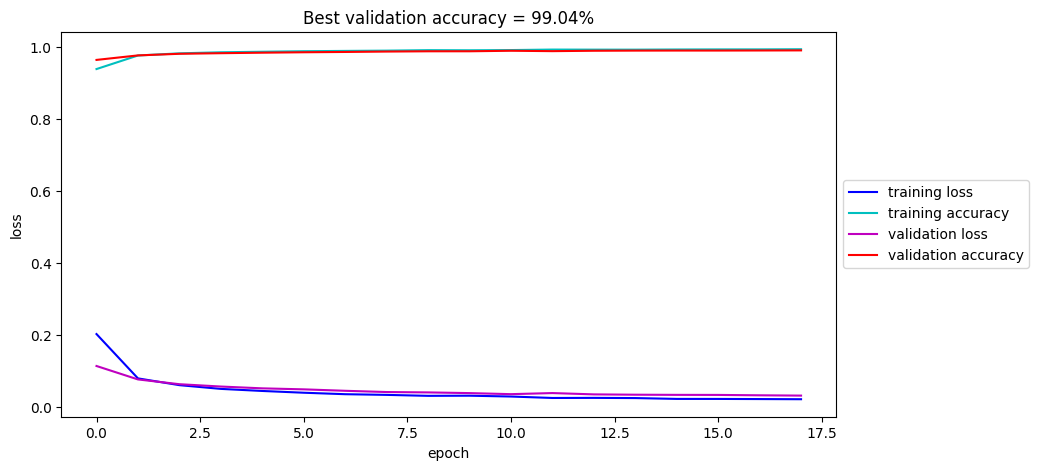

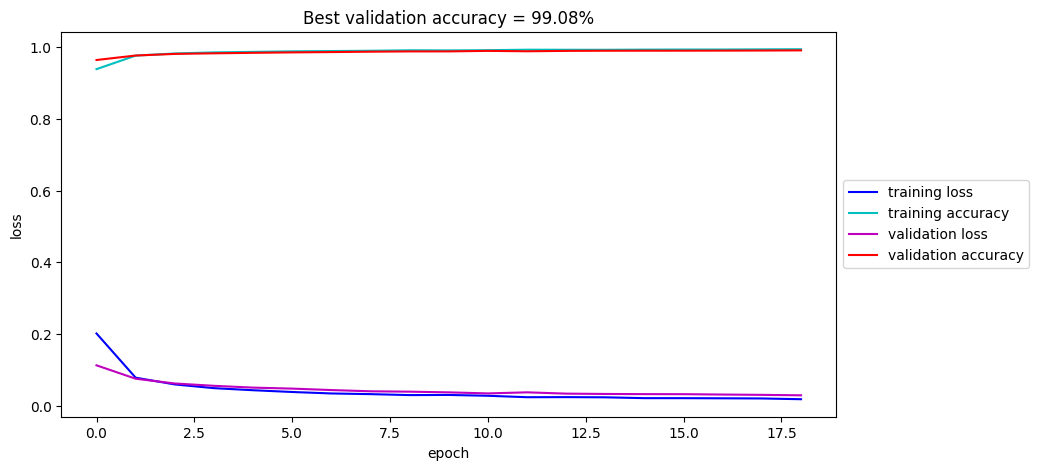

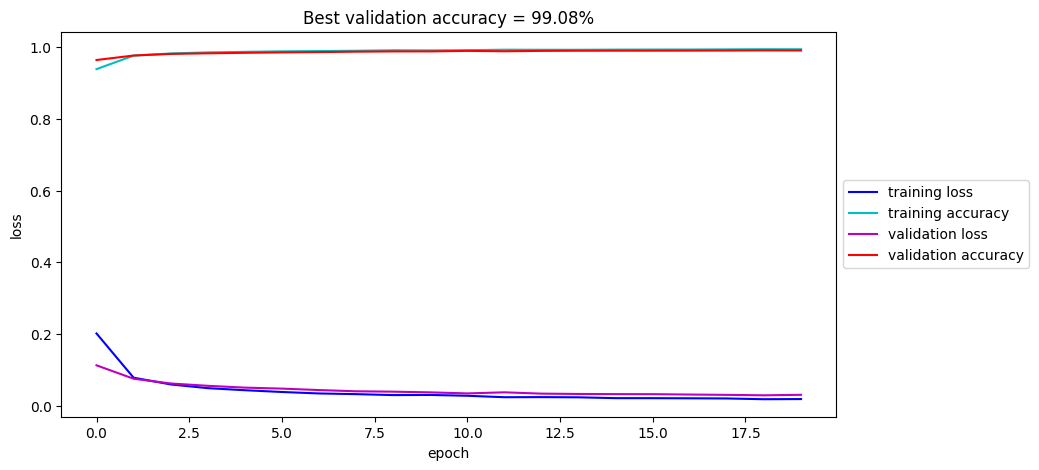

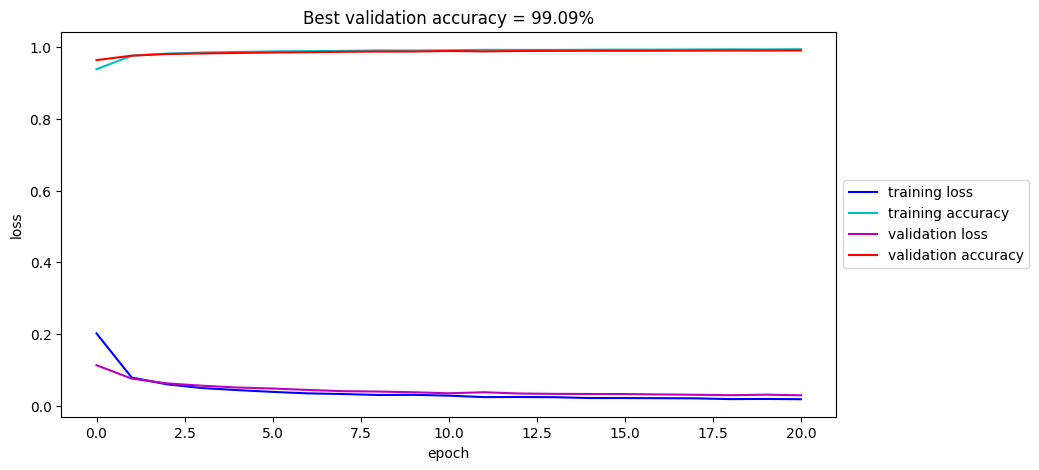

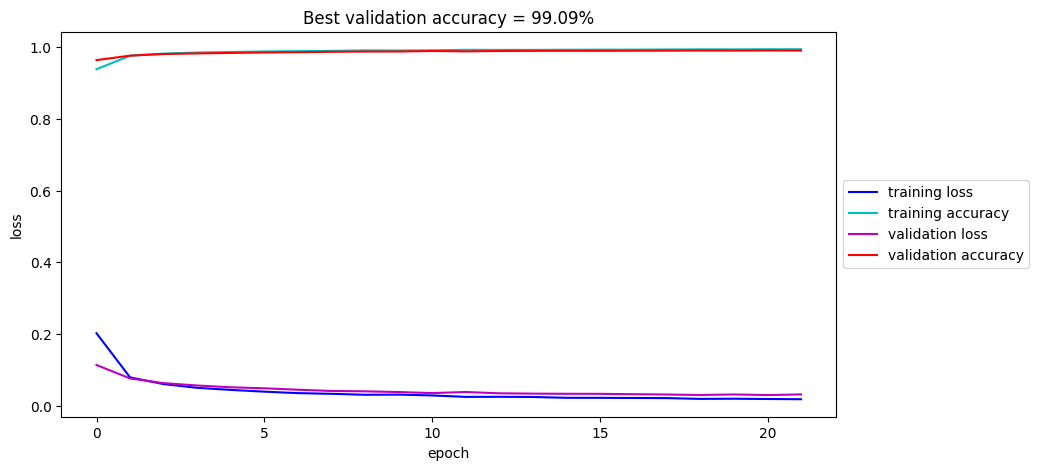

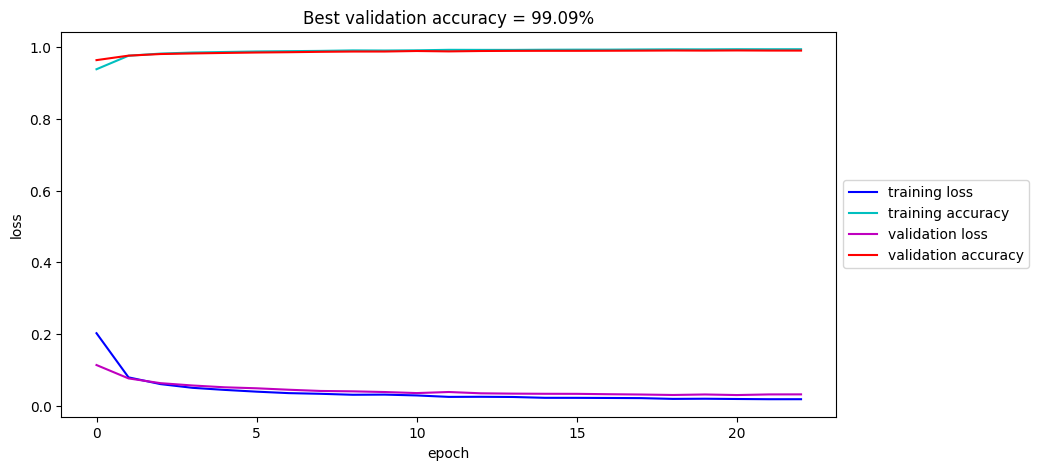

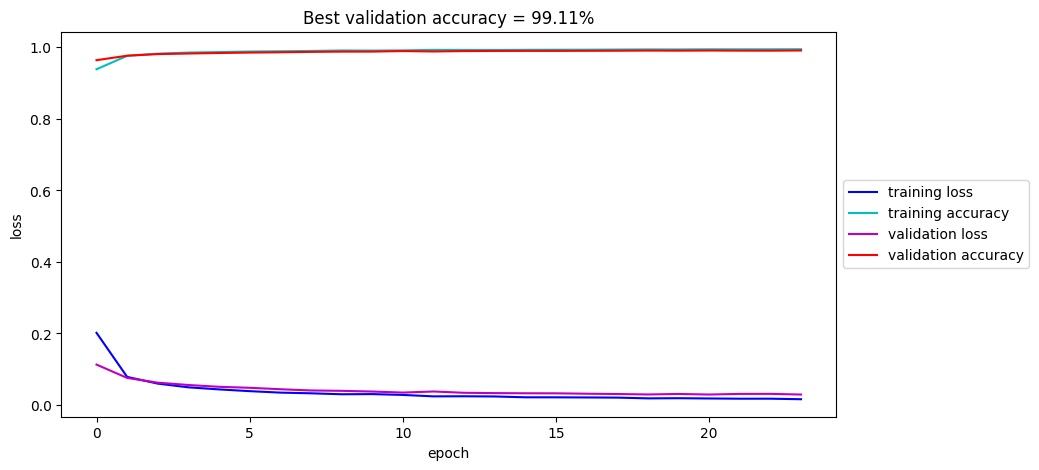

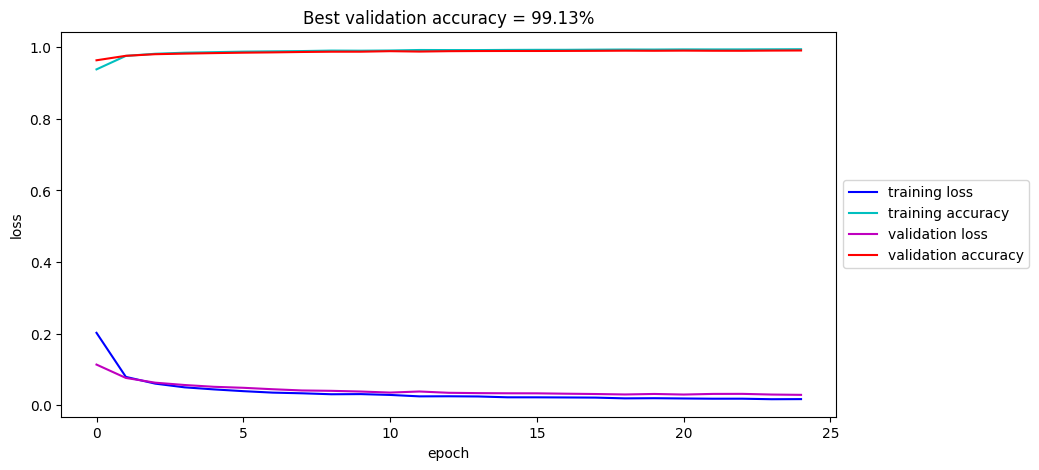

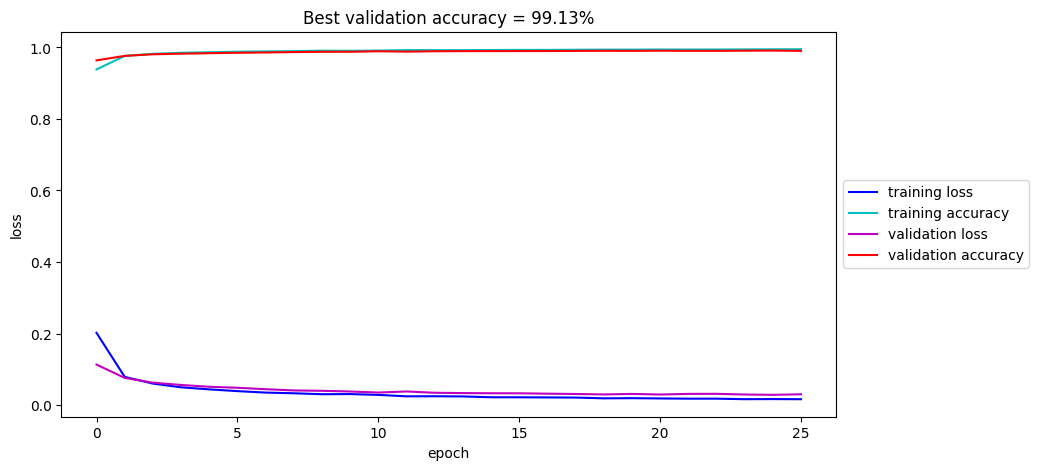

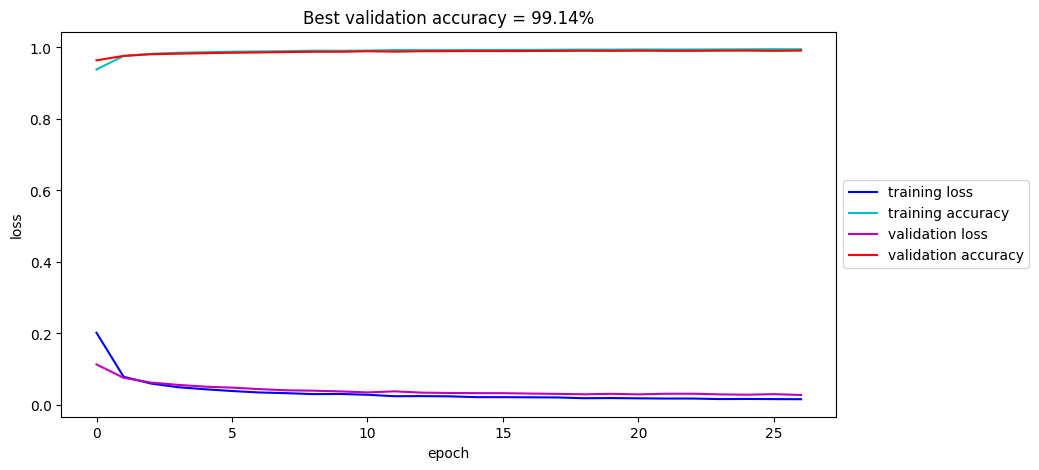

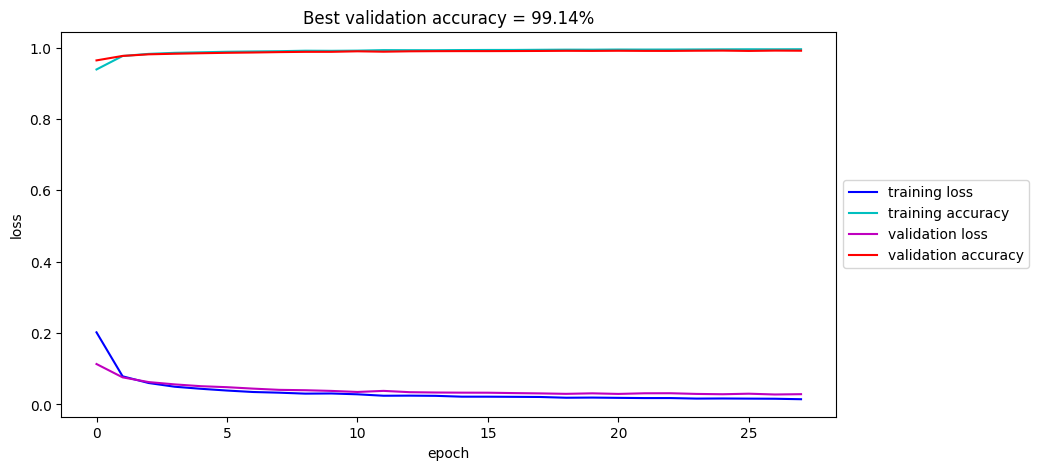

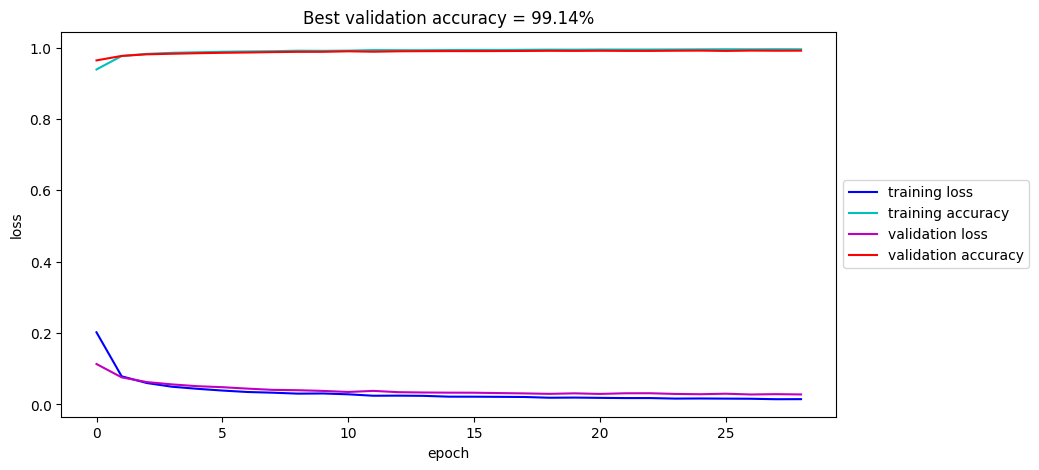

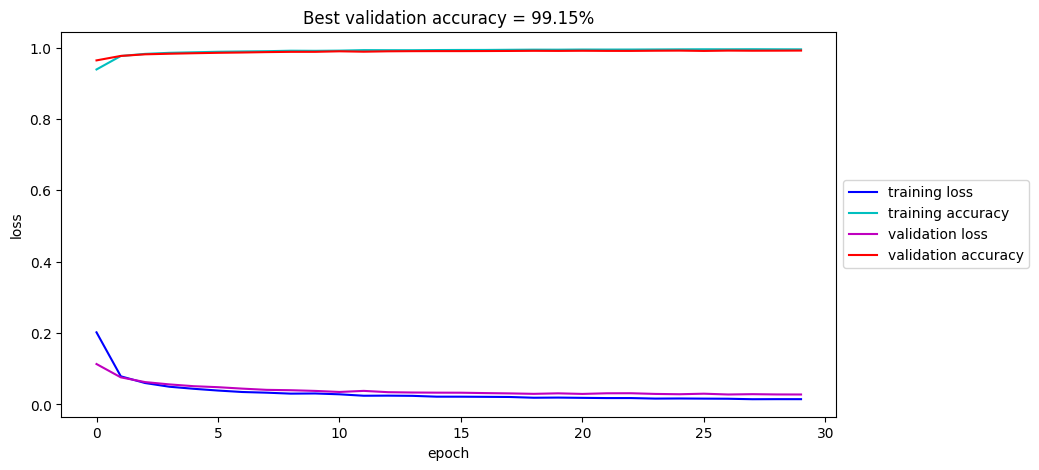

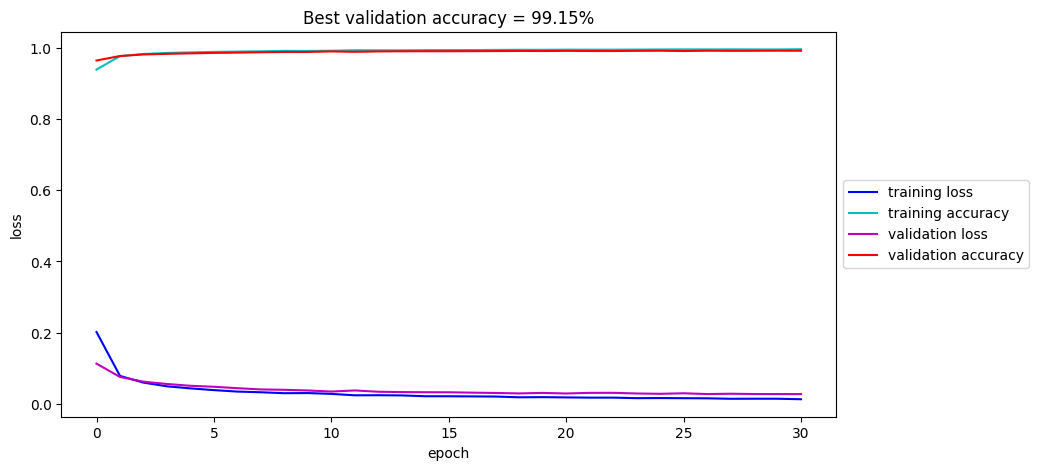

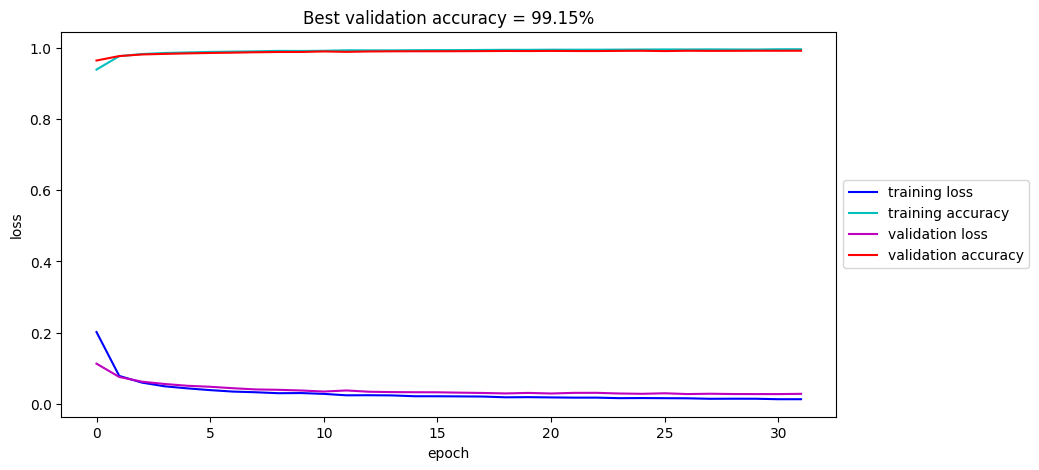

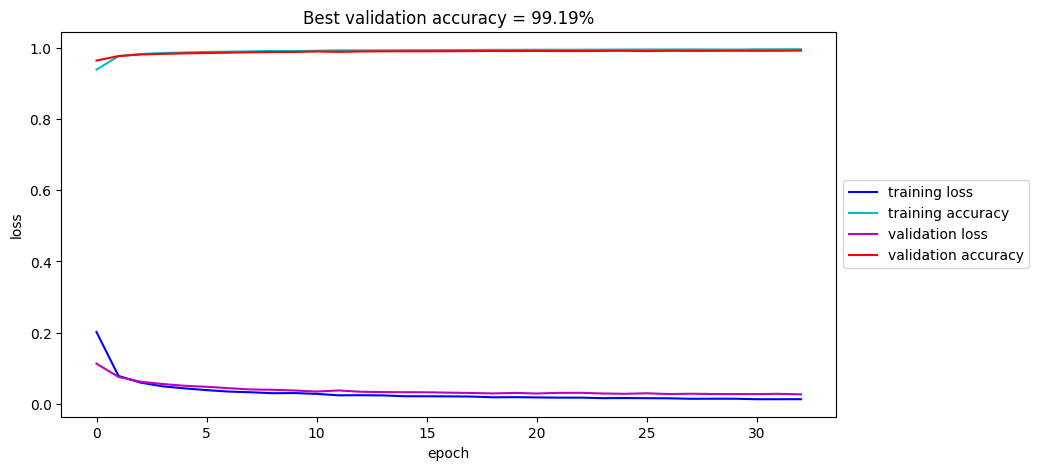

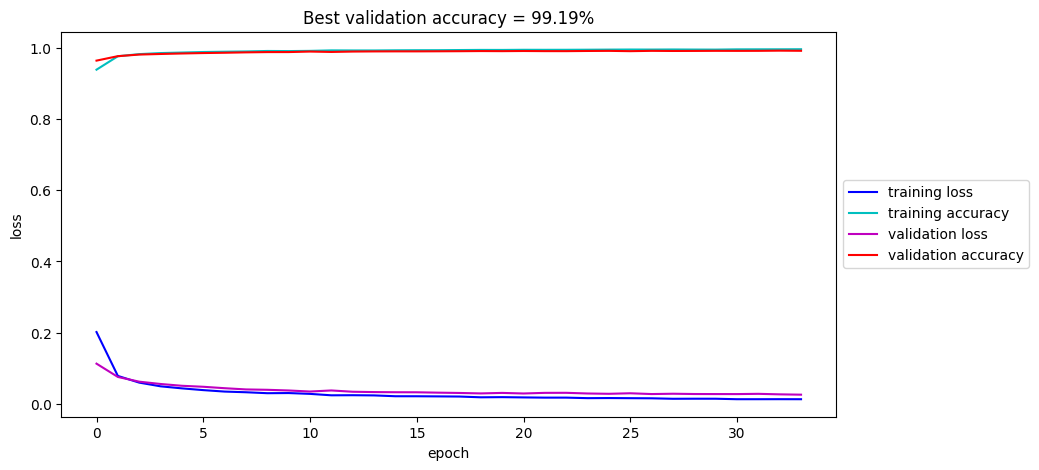

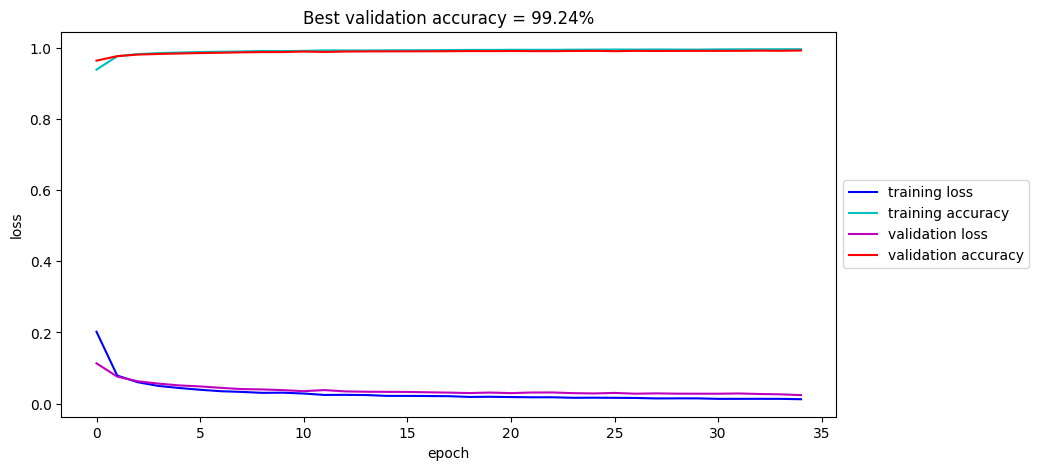

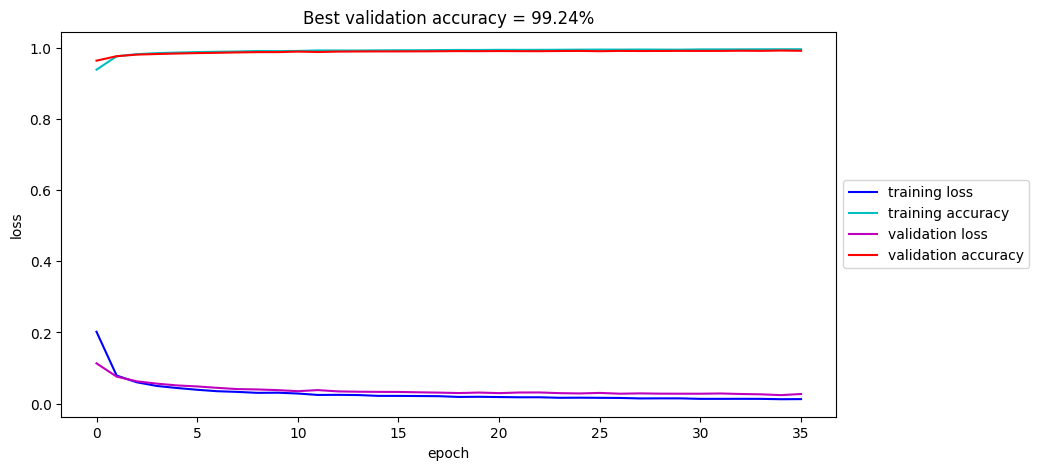

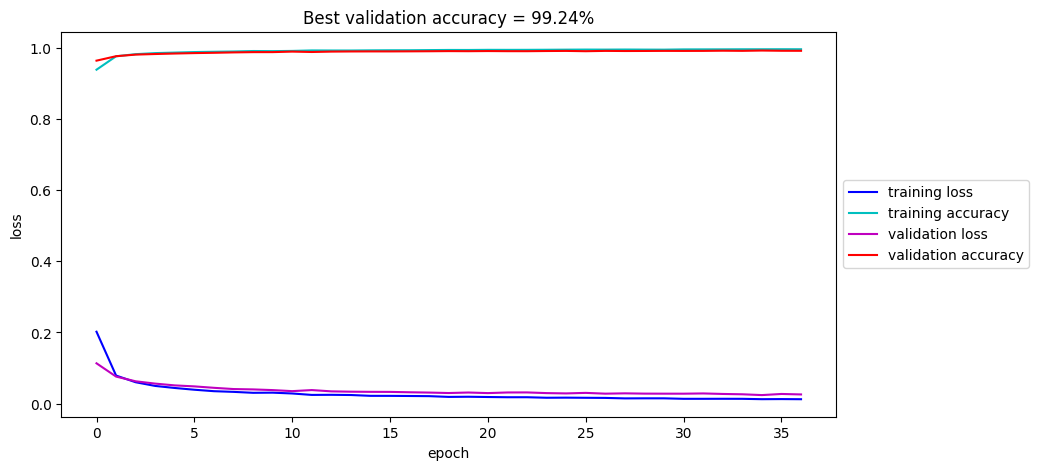

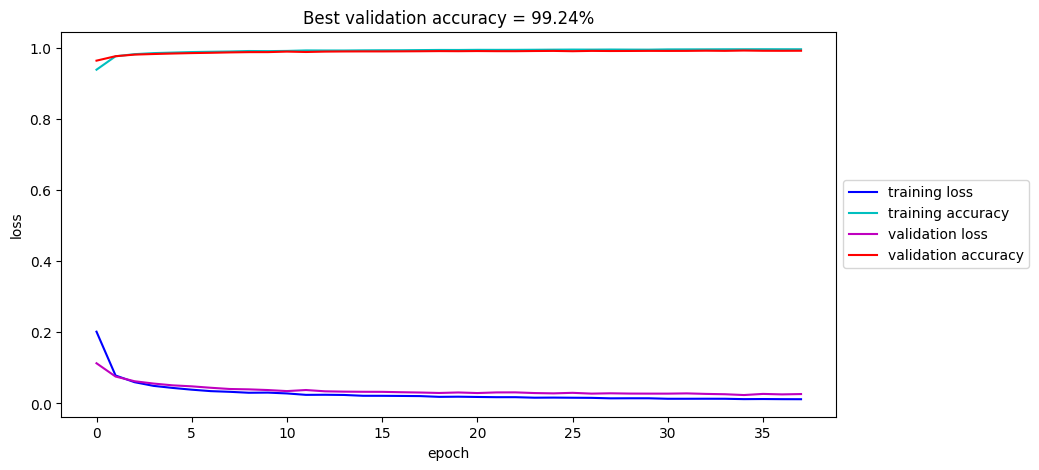

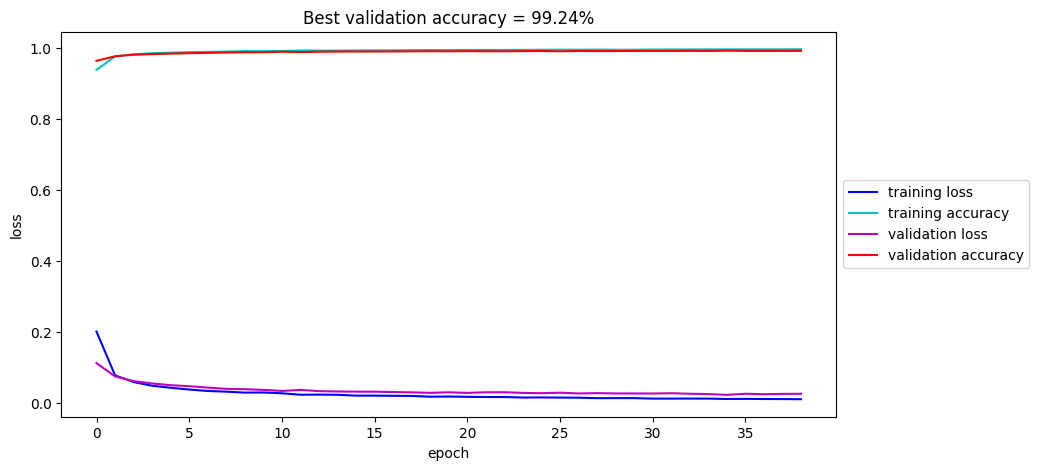

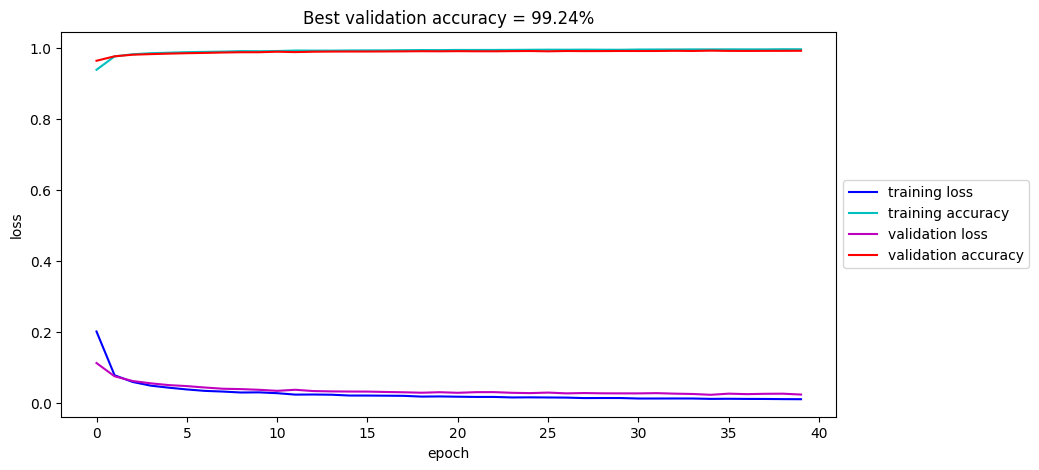

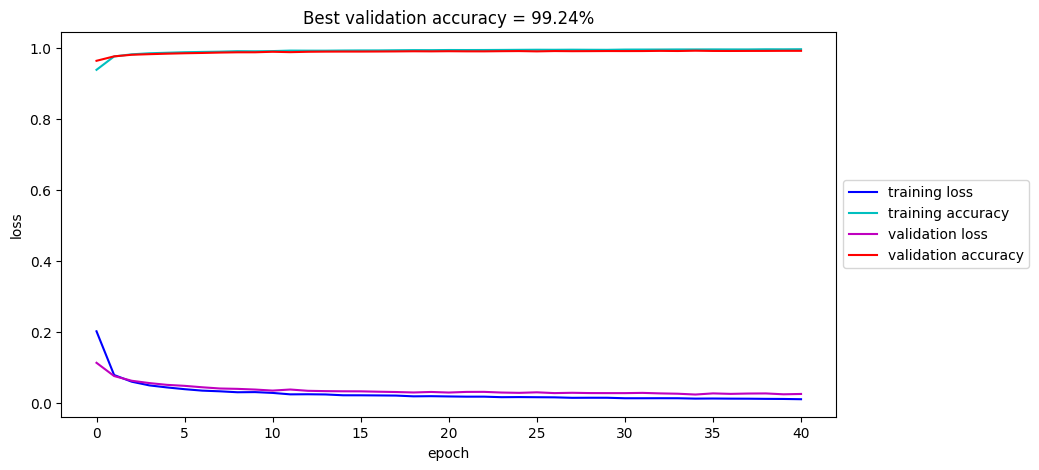

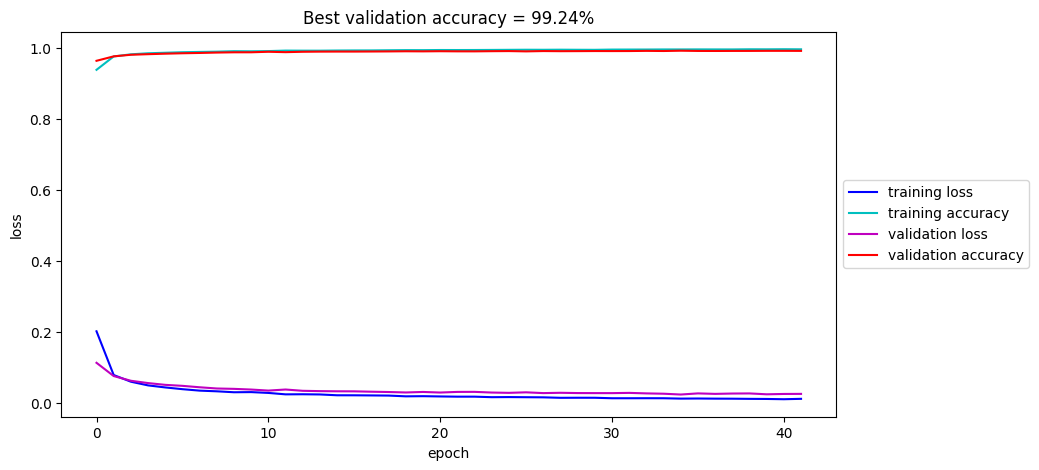

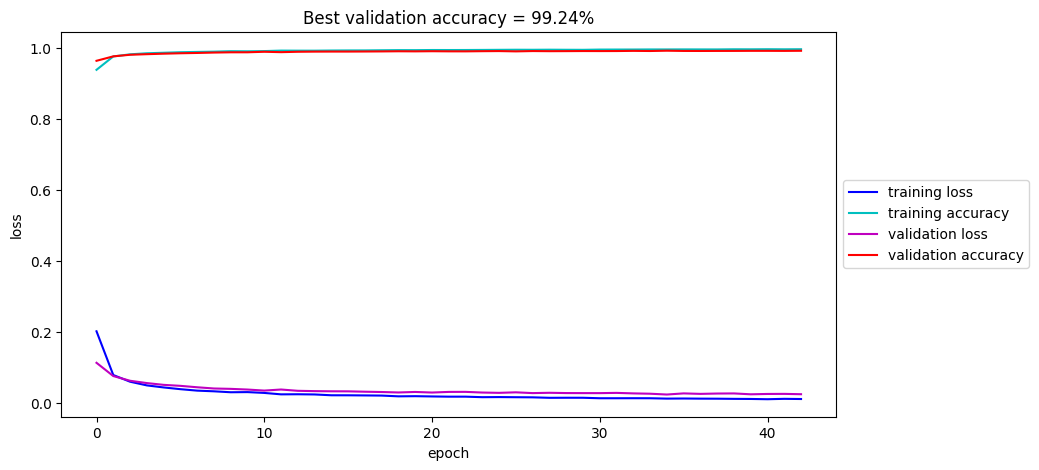

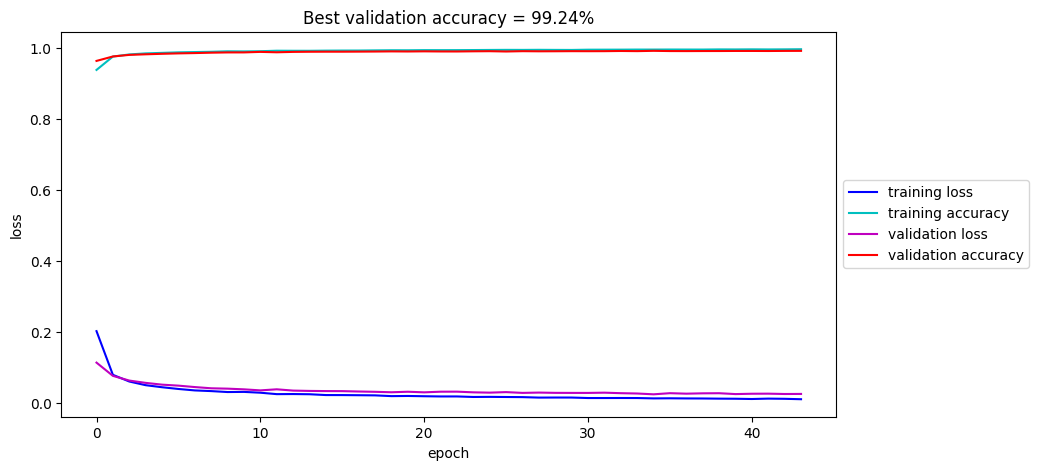

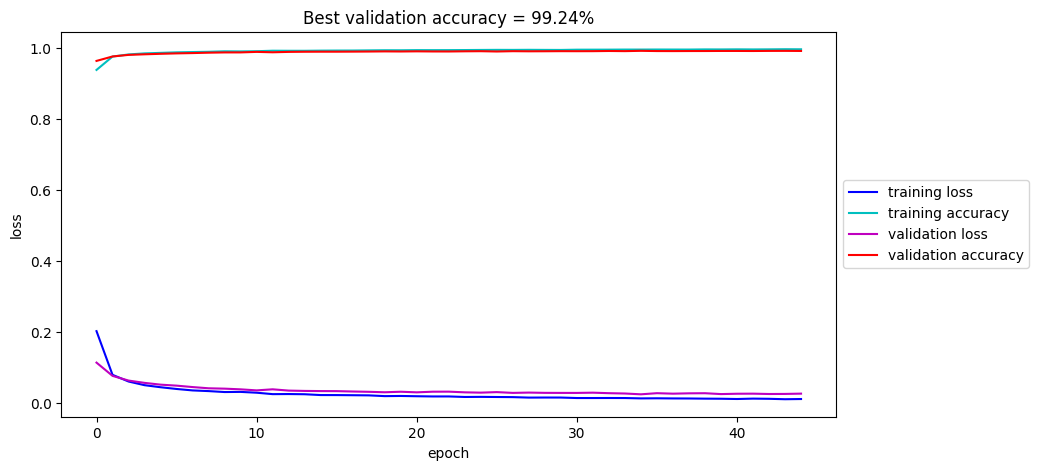

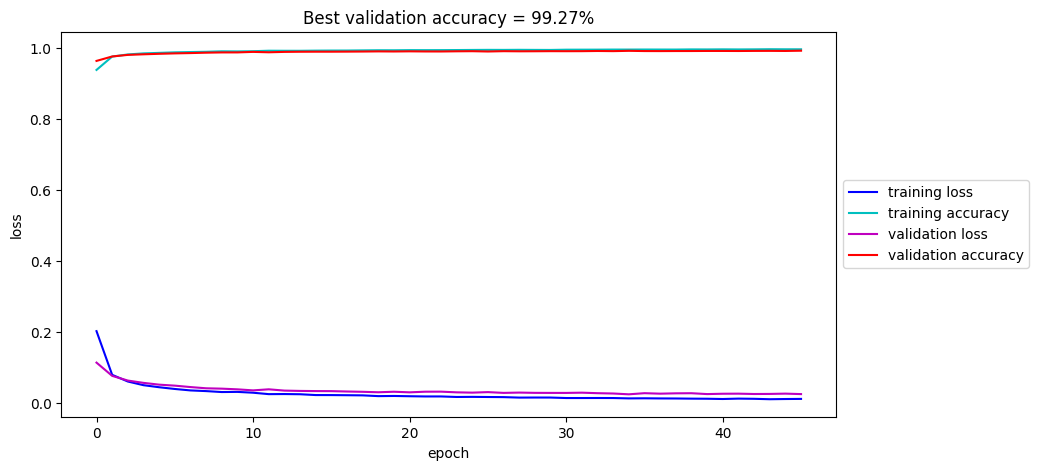

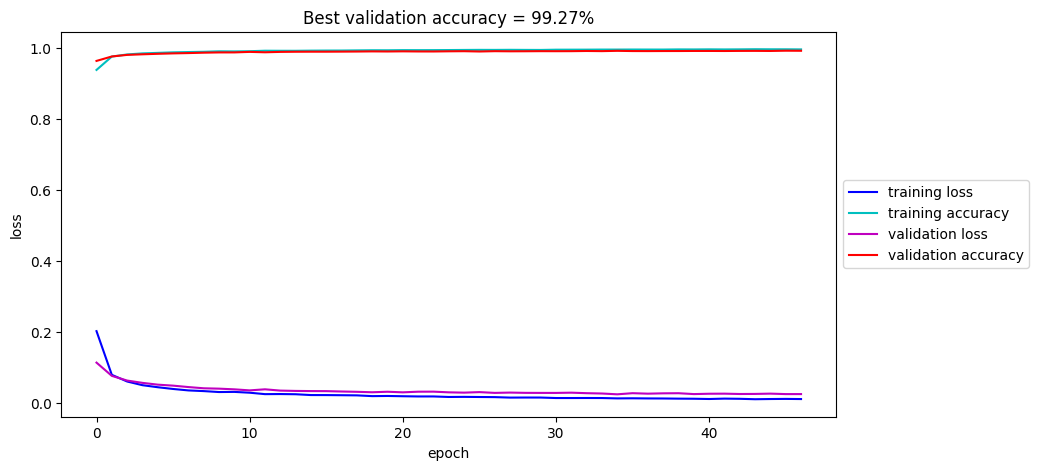

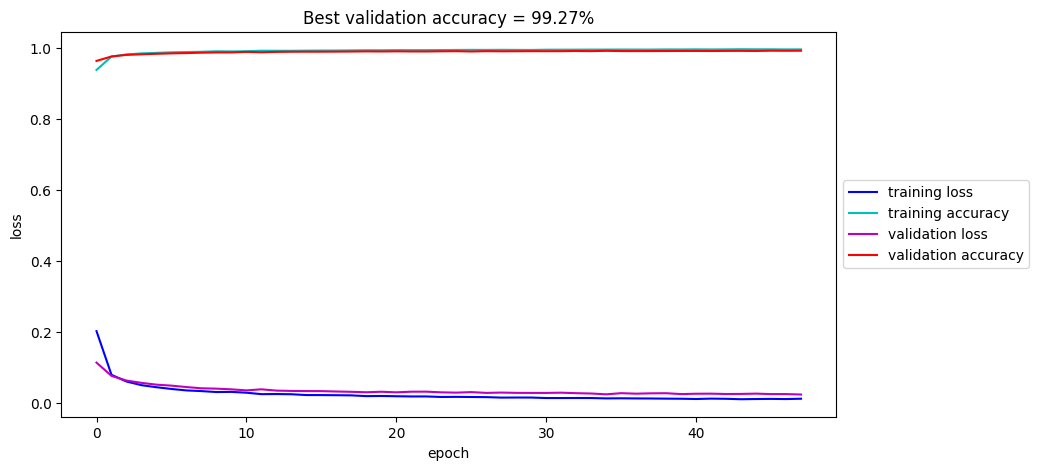

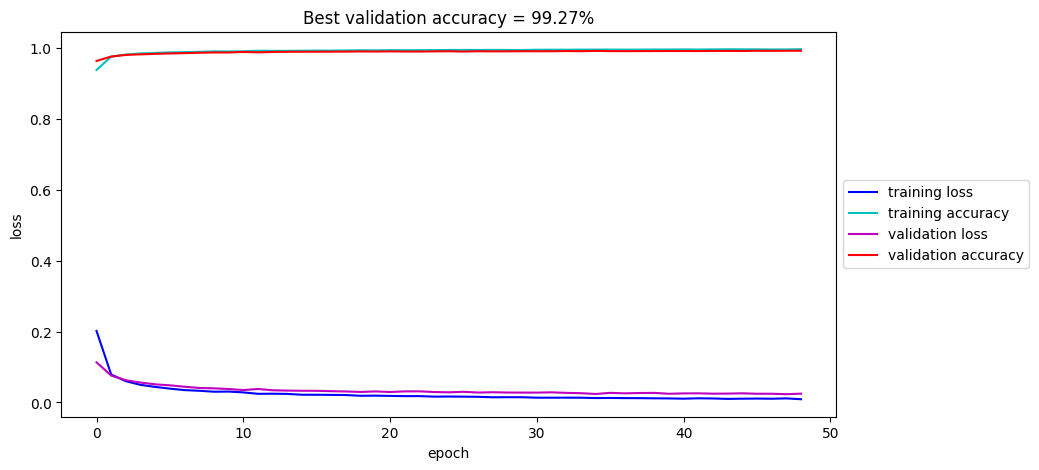

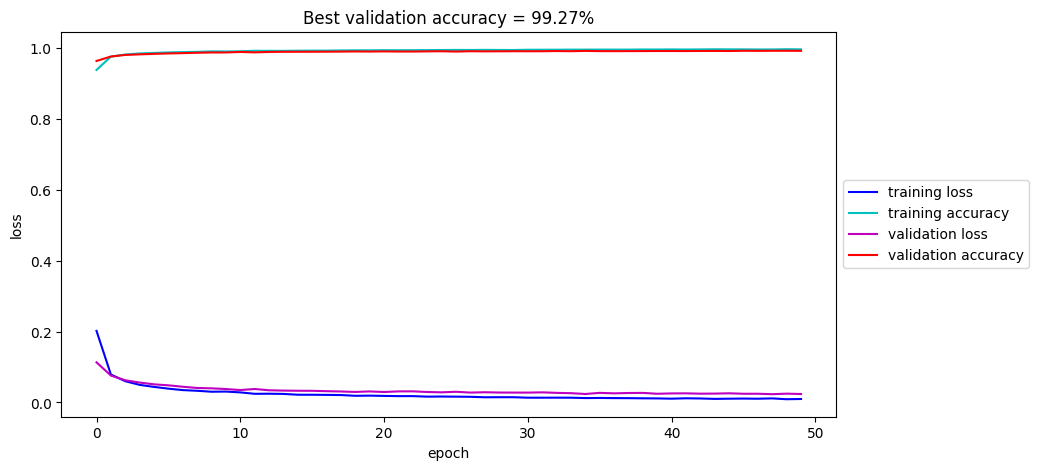

In [ ]:
train_network(network_sgd, X_train, y_train,
              X_test, y_test, n_epoch, batch_size, network_filepath)

# Conclusion
The results show that if we use Adam's optimizer with appropriate hyperparameters then we can get better results.


---

According to the above results, the best validation accuracy with Adam's optimizer is 99.45%. However, this accuracy with SGD optimizer is 99.27%.

# Evaluation the best network

625/625 [==============================] - 1s 2ms/step


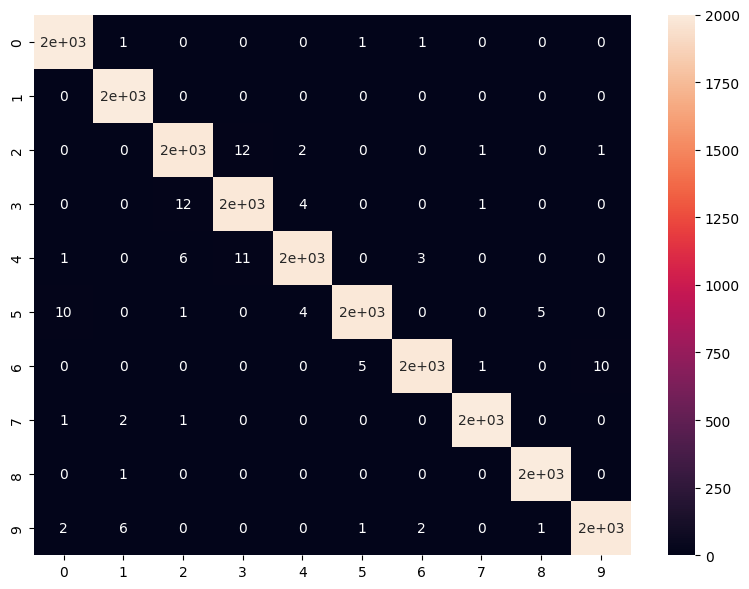

Classification Report:

              precision    recall  f1-score   support



         0.0       0.99      1.00      1.00      2000

         1.0       1.00      1.00      1.00      2000

         2.0       0.99      0.99      0.99      2000

         3.0       0.99      0.99      0.99      2000

         4.0       0.99      0.99      0.99      2000

         5.0       1.00      0.99      0.99      2000

         6.0       1.00      0.99      0.99      2000

         7.0       1.00      1.00      1.00      2000

         8.0       1.00      1.00      1.00      2000

         9.0       0.99      0.99      0.99      2000



    accuracy                           0.99     20000

   macro avg       0.99      0.99      0.99     20000

weighted avg       0.99      0.99      0.99     20000




In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns

# Evaluate the model
best_network = tf.keras.models.load_model('/content/best_model_CNNs_with_adam_optimizer.h5')
y_pred = best_network.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

# Confusion Matrix:
plt.figure(figsize=(8,6))
labels_numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
conf_matrix = confusion_matrix(y_test, y_pred, labels=labels_numbers)
df_cm = pd.DataFrame(conf_matrix, index=labels_numbers, columns=labels_numbers)
sns.heatmap(df_cm, annot=True)
plt.tight_layout()
plt.show()

print("Classification Report:")
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)